In [320]:
import pandas as pd
# from matplotlib import pyplot
import numpy as np
import seaborn as sns
import math
import datetime
import pickle
import joblib
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

model_rfr_ftr = joblib.load('savemodel_rfr_ftr.sav')
# model_rfr_hpo = joblib.load('savemodel_rfr_ftr_hpo.sav')
model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov.sav')
# model_rft = joblib.load('savemodel_rf.sav')


model_etr = joblib.load('savemodel_etr.sav')
model_etr_hpov = joblib.load('savemodel_etr_hpov.sav')

model_dtr_ftr = joblib.load('savemodel_dtr_ftr.sav')
model_dtr_hpov = joblib.load('savemodel_dtr_hpov.sav')


model_mlr_ftr = joblib.load('savemodel_mlr_ftr.sav')

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [321]:
# Drop the wind speed and current speed from the original dataset as it contains outlier 

dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [322]:
# Drop all dulplicate feature in dataset "AIS_weather_h_rename_copy.csv"

dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
count,7453.000000,7453.000000,5941.000000,5941.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.016286,0.003318,8.870751,242.699284
std,5.296850,4.429899,0.099475,0.081795,8.619512,108.555287
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241
25%,-1.756650,-2.534061,-0.037983,-0.044471,0.000000,124.116508
50%,2.294543,0.385690,0.019269,0.003562,6.953578,283.216008
75%,5.838650,3.339456,0.072372,0.047412,18.014436,346.200000
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115


Imputing value in the preprocessed dataset

In [323]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [324]:
x_pre = imputer.transform(dfpre)

In [325]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [326]:
# Calculate current and wind speed

dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [327]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,0.096788,6.513813
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,0.067697,3.048934
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,0.047447,4.149883
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,0.079148,6.285080
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,0.128444,8.525129
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,16.760001


In [328]:
# Calculate the True North wind direction and split them into quadrants

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))


In [329]:
# Calculate the True North current direction and split them into quadrants

condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [330]:
# Descriptive statistics of the dataset for true north weather direction

dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [331]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,0.122270,7.112664,251.408180,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,0.122270,6.653538,254.458891,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,0.099846,6.488697,259.749663,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,0.099846,6.104632,266.724504,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,0.099846,6.181707,174.494060,57.259552


In [332]:
# SOG threshold according to Abebe20 and Yan21

df = df[df['SOG'] > 5 ]

# # Improve model performance ? , reduce skew of the dataset by applying higher threshold

# df = df[df['SOG'] > 12 ]

In [333]:
# Exclude data for the month of June to check the model's forecasting performance 

from sklearn.model_selection import train_test_split

#When performing the split, make sure that the random state is the same as the training script

train_set, test_set = train_test_split(df, test_size=0.25, random_state=42)

# Summer
dfMay = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-05']
print(f"length of May dataset {len(dfMay)}")
dfJune = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-06']
print(f"length of June dataset {len(dfJune)}")
dfJuly = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-07']
print(f"length of July dataset {len(dfJuly)}")
dfAug = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-08']
print(f"length of August dataset {len(dfAug)}")
dfSep = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-09']
print(f"length of Sept dataset {len(dfSep)}")
dfOct = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-10']
print(f"length of Oct dataset {len(dfOct)}")
print("#########################################")
# Winter
dfNov = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-11']
print(f"length of Nov dataset {len(dfNov)}")
dfDec = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-12']
print(f"length of Dec dataset {len(dfDec)}")
dfJan = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-01']
print(f"length of Jan dataset {len(dfJan)}")
dfFeb = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-02']
print(f"length of Feb dataset {len(dfFeb)}")
dfMar = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-03']
print(f"length of March dataset {len(dfMar)}")
dfApr = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-04']
print(f"length of April dataset {len(dfApr)}")


frames_summer = [dfMay,dfJune,dfJuly,dfAug,dfSep,dfOct]
frames_winter = [dfNov,dfDec,dfJan,dfFeb,dfMar,dfApr]

dfsummer = pd.concat(frames_summer)
dfwinter = pd.concat(frames_winter)
dfyear = test_set

# df_test_set = dfwinter
# df_test_set = dfsummer  
# df_test_set= test_set



length of May dataset 35
length of June dataset 70
length of July dataset 70
length of August dataset 70
length of Sept dataset 77
length of Oct dataset 60
#########################################
length of Nov dataset 65
length of Dec dataset 61
length of Jan dataset 79
length of Feb dataset 78
length of March dataset 56
length of April dataset 67


In [334]:
dfsummer.describe()

,Unnamed: 0,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
count,382.000000,382.000000,382.000000,382.000000,369.000000,368.000000,368.000000,368.000000,368.000000,368.000000,...,382.000000,382.000000,382.000000,368.000000,368.000000,368.000000,382.000000,382.000000,382.000000,382.000000
mean,4367.238220,13.395865,55.237965,286.039109,1.228968,1.396753,4.006831,3.336382,3.610851,286.622051,...,198.726570,91.548465,83.470183,89.515153,87.110286,88.285184,0.098119,6.377085,188.815257,146.586541
std,1751.144389,0.672044,0.084750,5.952871,0.029646,1.117895,1.101201,0.974187,0.953878,5.206667,...,89.103658,56.938332,59.420914,59.076600,53.547910,59.787774,0.072349,3.148621,87.415752,103.202239
min,121.000000,12.369663,55.040170,269.218018,1.175910,0.168145,2.017009,1.553870,2.006727,274.747070,...,67.902386,0.427861,0.261234,0.761416,0.070775,0.200645,0.007685,0.398818,1.305558,3.117300
25%,3302.250000,12.864115,55.175267,283.330444,1.207337,0.582866,3.118395,2.524268,2.833582,283.204376,...,99.928632,37.668581,25.351309,30.803190,40.022543,28.557090,0.048138,4.134336,122.299646,69.469908
50%,4557.500000,13.401606,55.232526,287.439697,1.224717,1.044311,3.910196,3.303151,3.464042,287.915466,...,271.545127,96.994073,70.221749,86.499680,82.199851,82.495845,0.076443,6.001820,196.615758,115.846038
75%,5729.500000,14.024926,55.274352,290.573608,1.244003,1.977732,4.750014,3.864906,4.278043,290.422363,...,279.553335,144.886990,143.545146,148.377806,133.802072,149.252824,0.127318,8.305133,258.972751,220.988745
max,7499.000000,14.540096,55.421096,295.699951,1.322246,5.272534,7.260825,6.635170,6.680546,294.928223,...,303.295177,179.451878,179.074917,179.733714,178.771464,179.918071,0.497666,15.423022,357.719936,358.829646


In [335]:
dfwinter.describe()

,Unnamed: 0,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
count,406.000000,406.000000,406.000000,406.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,...,406.000000,406.000000,406.000000,391.000000,391.000000,391.000000,406.000000,406.000000,406.000000,406.000000
mean,3463.591133,13.432904,55.231412,279.211044,1.259188,1.475426,4.217225,3.306767,3.734537,280.080418,...,197.217204,86.978001,98.108861,90.317073,93.082095,92.047447,0.102562,6.730687,205.365358,149.626926
std,2692.916331,0.679927,0.082805,4.952724,0.027033,0.943588,0.938370,0.860050,0.792622,4.505709,...,89.480575,55.226737,55.459410,53.162077,53.035547,53.989807,0.065985,2.813988,93.326017,100.132305
min,9.000000,12.390440,55.099397,267.095032,1.190862,0.083379,1.681843,1.538978,1.672565,273.685059,...,89.221494,0.134469,0.554401,0.224403,0.803317,0.464269,0.003022,0.427826,0.232451,0.172301
25%,1146.250000,12.889470,55.161883,276.021851,1.243546,0.744205,3.579990,2.660882,3.171935,277.088135,...,99.545819,34.480850,45.033128,42.007541,46.197209,42.664214,0.053173,4.495645,156.736613,74.601322
50%,2457.500000,13.352161,55.230980,278.197998,1.263435,1.254463,4.142624,3.323341,3.643467,278.608887,...,271.532933,85.257275,102.099316,90.919305,96.620207,94.117560,0.088244,6.657582,209.093121,120.773114
75%,6704.000000,14.074220,55.271904,280.745361,1.276688,2.030829,4.866672,3.864906,4.294728,282.113648,...,280.764497,136.758689,149.515594,137.859931,140.093470,140.725550,0.136914,8.716621,279.892393,215.617778
max,7975.000000,14.541027,55.419592,292.686035,1.328551,5.117811,6.811666,5.636391,5.741870,292.428223,...,305.179356,179.858625,179.820002,179.032393,179.813891,179.070676,0.364092,14.498614,358.907188,359.264290


In [336]:
dfyear.describe()

,Unnamed: 0,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
count,788.000000,788.000000,788.000000,788.000000,760.000000,759.000000,759.000000,759.000000,759.000000,759.000000,...,788.000000,788.000000,788.000000,759.000000,759.000000,759.000000,788.000000,788.000000,788.000000,788.000000
mean,3901.653553,13.414949,55.234589,282.521096,1.244515,1.437282,4.115216,3.321126,3.674568,283.252119,...,197.948902,89.193632,91.012446,89.928264,90.186672,90.223320,0.100408,6.559270,197.342340,148.153034
std,2328.224161,0.675941,0.083764,6.437256,0.032095,1.031847,1.025301,0.916675,0.876131,5.854345,...,89.244511,56.073901,57.842459,56.071816,53.333084,56.868178,0.069135,2.984239,90.829671,101.578774
min,9.000000,12.369663,55.040170,267.095032,1.175910,0.083379,1.681843,1.538978,1.672565,273.685059,...,67.902386,0.134469,0.261234,0.224403,0.070775,0.200645,0.003022,0.398818,0.232451,0.172301
25%,1796.500000,12.881823,55.171672,276.994385,1.218604,0.653328,3.325537,2.583625,2.979597,277.894897,...,99.761126,35.900782,38.079257,34.688386,41.700811,35.927965,0.051704,4.274962,139.472374,71.822843
50%,3909.500000,13.382291,55.231658,281.952637,1.244869,1.157148,4.065469,3.314369,3.578332,282.659058,...,271.532933,89.391535,89.815770,89.251025,89.601332,87.682543,0.080828,6.471532,204.717196,119.500471
75%,5865.000000,14.033641,55.273204,288.729340,1.269579,2.010343,4.802534,3.864906,4.286223,288.907776,...,280.379787,141.618781,145.791478,143.391851,136.527205,145.005246,0.132449,8.475245,274.637991,218.434873
max,7975.000000,14.541027,55.421096,295.699951,1.328551,5.272534,7.260825,6.635170,6.680546,294.928223,...,305.179356,179.858625,179.820002,179.733714,179.813891,179.918071,0.497666,15.423022,358.907188,359.264290


Exporting File

In [337]:
# df.to_csv('June_update.csv')

Measure performance in Season, data pre processing by dropping unnecessary feature and renaming


In [338]:
# For Summer
dfsummer= dfsummer.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
# For Winter
dfwinter= dfwinter.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
# For the whole year of 2021
dfyear= dfyear.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)


In [339]:
#For Summer
dfsummer= dfsummer.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 
#For Winter
dfwinter= dfwinter.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 
#For the whole year
dfyear= dfyear.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [340]:
# Rearrange column to match model 
# Also dropping the features as described in the main script

# For summer 
dfsummer = dfsummer[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]
# For Winter
dfwinter = dfwinter[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

# For the whole year
dfyear = dfyear[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]




Imputing to complete the data

In [341]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)


In [342]:
# Impute for different dataframe 

imputer.fit(dfsummer)
imputer.fit(dfwinter)
imputer.fit(dfyear)

KNNImputer(n_neighbors=50)

In [343]:
xsummer = imputer.transform(dfsummer)
xwinter = imputer.transform(dfwinter)
xyear = imputer.transform(dfyear)

In [344]:
df_summer_tr = pd.DataFrame(xsummer, columns=dfsummer.columns, index=dfsummer.index)
df_winter_tr = pd.DataFrame(xwinter, columns=dfwinter.columns, index=dfwinter.index)
df_year_tr = pd.DataFrame(xyear, columns=dfyear.columns, index=dfyear.index)

In [345]:
# Summer dataset
x_date_s = df_summer_tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
y_date_s = df_summer_tr.sog
# winter dataset
x_date_w = df_winter_tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
y_date_w = df_winter_tr.sog
# Year dataset
x_date_yr = df_year_tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
y_date_yr = df_year_tr.sog

In [346]:
print(f"Amount of the test dataset is {len(x_date_yr)}")
print(f"Amount of the summer dataset is {len(x_date_s)}")
print(f"Amount of the winter dataset is {len(x_date_w)}")

Amount of the test dataset is 788
Amount of the summer dataset is 382
Amount of the winter dataset is 406


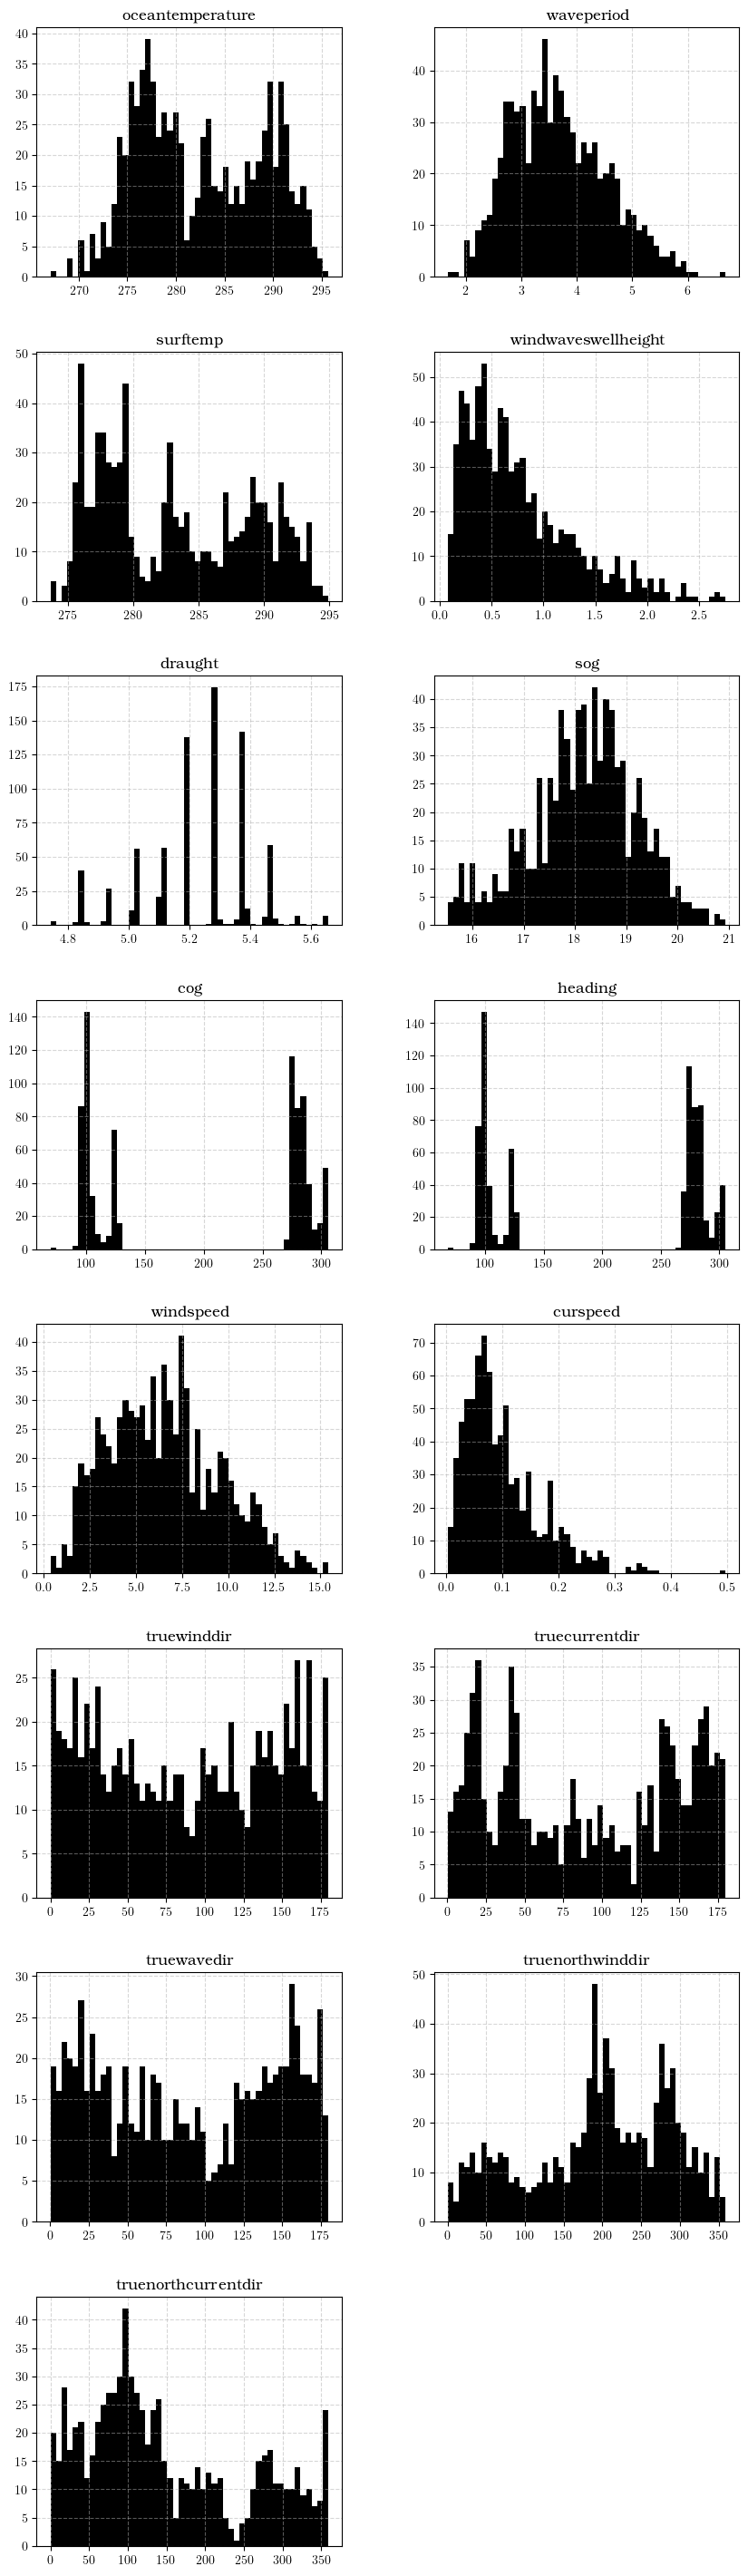

In [347]:
# plt.rcParams.update(plt.rcParamsDefault) # Alter default value 
axes = df_year_tr.hist(bins=50,figsize=(10,50),color='black',grid=True,layout=(11,2))
for ax in axes.flatten():
    ax.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [348]:
x_date_yr.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000
mean,282.521096,3.673747,283.252584,0.755916,5.233213,200.016135,197.948902,6.559270,0.100408,89.193632,91.012446,90.511605
std,6.437256,0.861528,5.749356,0.518801,0.177176,89.588185,89.244511,2.984239,0.069135,56.073901,57.842459,56.509129
min,267.095032,1.672565,273.685059,0.075465,4.742517,69.768055,67.902386,0.398818,0.003022,0.134469,0.261234,0.200645
25%,276.994385,3.001080,277.983673,0.361698,5.110946,100.866831,99.761126,4.274962,0.051704,35.900782,38.079257,36.217798
50%,281.952637,3.586478,282.756714,0.626795,5.288063,273.604968,271.532933,6.471532,0.080828,89.391535,89.815770,88.335343
75%,288.729340,4.263344,288.714355,1.026444,5.377520,283.020862,280.379787,8.475245,0.132449,141.618781,145.791478,144.809243
max,295.699951,6.680546,294.928223,2.756067,5.658523,305.989862,305.179356,15.423022,0.497666,179.858625,179.820002,179.918071


In [349]:
stats_DSyear = x_date_yr.describe().transpose()
print(stats_DSyear.to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,

))  

\begin{tabular}{rrrrrrrr}
\toprule
 count &   mean &   std &    min &    25\% &    50\% &    75\% &    max \\
\midrule
788.00 & 282.52 &  6.44 & 267.10 & 276.99 & 281.95 & 288.73 & 295.70 \\
788.00 &   3.67 &  0.86 &   1.67 &   3.00 &   3.59 &   4.26 &   6.68 \\
788.00 & 283.25 &  5.75 & 273.69 & 277.98 & 282.76 & 288.71 & 294.93 \\
788.00 &   0.76 &  0.52 &   0.08 &   0.36 &   0.63 &   1.03 &   2.76 \\
788.00 &   5.23 &  0.18 &   4.74 &   5.11 &   5.29 &   5.38 &   5.66 \\
788.00 & 200.02 & 89.59 &  69.77 & 100.87 & 273.60 & 283.02 & 305.99 \\
788.00 & 197.95 & 89.24 &  67.90 &  99.76 & 271.53 & 280.38 & 305.18 \\
788.00 &   6.56 &  2.98 &   0.40 &   4.27 &   6.47 &   8.48 &  15.42 \\
788.00 &   0.10 &  0.07 &   0.00 &   0.05 &   0.08 &   0.13 &   0.50 \\
788.00 &  89.19 & 56.07 &   0.13 &  35.90 &  89.39 & 141.62 & 179.86 \\
788.00 &  91.01 & 57.84 &   0.26 &  38.08 &  89.82 & 145.79 & 179.82 \\
788.00 &  90.51 & 56.51 &   0.20 &  36.22 &  88.34 & 144.81 & 179.92 \\
\bottomrule
\end{

C:\Users\Wafi\AppData\Local\Temp\ipykernel_16904\243031061.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_DSyear.to_latex(index=False,


In [350]:
y_date_yr.describe()

count    788.000000
mean      18.173585
std        1.039384
min       15.512127
25%       17.564763
50%       18.222930
75%       18.843612
max       20.935741
Name: sog, dtype: float64

In [351]:
x_date_s.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,286.039109,3.609926,286.511220,0.735343,5.292749,201.070397,198.726570,6.377085,0.098119,91.548465,83.470183,88.431177
std,5.952871,0.936796,5.147199,0.562787,0.155999,89.662852,89.103658,3.148621,0.072349,56.938332,59.420914,59.240725
min,269.218018,2.006727,274.747070,0.099744,4.748948,69.768055,67.902386,0.398818,0.007685,0.427861,0.261234,0.200645
25%,283.330444,2.853830,283.124207,0.330512,5.199738,101.446594,99.928632,4.134336,0.048138,37.668581,25.351309,29.155265
50%,287.439697,3.481118,287.731689,0.574301,5.290621,273.632539,271.545127,6.001820,0.076443,96.994073,70.221749,82.689301
75%,290.573608,4.219124,290.305908,0.986234,5.380782,282.779683,279.553335,8.305133,0.127318,144.886990,143.545146,148.952687
max,295.699951,6.680546,294.928223,2.756067,5.658523,305.416681,303.295177,15.423022,0.497666,179.451878,179.074917,179.918071


In [352]:
stats_DSsummer = x_date_s.describe().transpose()
print(stats_DSsummer.to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,

))  

\begin{tabular}{rrrrrrrr}
\toprule
 count &   mean &   std &    min &    25\% &    50\% &    75\% &    max \\
\midrule
382.00 & 286.04 &  5.95 & 269.22 & 283.33 & 287.44 & 290.57 & 295.70 \\
382.00 &   3.61 &  0.94 &   2.01 &   2.85 &   3.48 &   4.22 &   6.68 \\
382.00 & 286.51 &  5.15 & 274.75 & 283.12 & 287.73 & 290.31 & 294.93 \\
382.00 &   0.74 &  0.56 &   0.10 &   0.33 &   0.57 &   0.99 &   2.76 \\
382.00 &   5.29 &  0.16 &   4.75 &   5.20 &   5.29 &   5.38 &   5.66 \\
382.00 & 201.07 & 89.66 &  69.77 & 101.45 & 273.63 & 282.78 & 305.42 \\
382.00 & 198.73 & 89.10 &  67.90 &  99.93 & 271.55 & 279.55 & 303.30 \\
382.00 &   6.38 &  3.15 &   0.40 &   4.13 &   6.00 &   8.31 &  15.42 \\
382.00 &   0.10 &  0.07 &   0.01 &   0.05 &   0.08 &   0.13 &   0.50 \\
382.00 &  91.55 & 56.94 &   0.43 &  37.67 &  96.99 & 144.89 & 179.45 \\
382.00 &  83.47 & 59.42 &   0.26 &  25.35 &  70.22 & 143.55 & 179.07 \\
382.00 &  88.43 & 59.24 &   0.20 &  29.16 &  82.69 & 148.95 & 179.92 \\
\bottomrule
\end{

C:\Users\Wafi\AppData\Local\Temp\ipykernel_16904\2468198302.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_DSsummer.to_latex(index=False,


In [353]:
y_date_s.describe()

count    382.000000
mean      18.315678
std        1.140272
min       15.532541
25%       17.619059
50%       18.398417
75%       19.201413
max       20.935741
Name: sog, dtype: float64

In [354]:
x_date_w.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000
mean,279.211044,3.733797,280.186577,0.775273,5.177197,199.024194,197.217204,6.730687,0.102562,86.978001,98.108861,92.469053
std,4.952724,0.780558,4.457583,0.473591,0.177812,89.617155,89.480575,2.813988,0.065985,55.226737,55.459410,53.812617
min,267.095032,1.672565,273.685059,0.075465,4.742517,94.003950,89.221494,0.427826,0.003022,0.134469,0.554401,0.464269
25%,276.021851,3.184935,277.176636,0.411536,5.026177,100.657039,99.545819,4.495645,0.053173,34.480850,45.033128,42.969736
50%,278.197998,3.652972,278.673889,0.671879,5.199724,273.592920,271.532933,6.657582,0.088244,85.257275,102.099316,94.352773
75%,280.745361,4.279978,282.513306,1.043923,5.290249,283.247224,280.764497,8.716621,0.136914,136.758689,149.515594,141.587718
max,292.686035,5.741870,292.428223,2.641841,5.555485,305.989862,305.179356,14.498614,0.364092,179.858625,179.820002,179.070676


In [355]:
stats_DSwinter = x_date_w.describe().transpose()
print(stats_DSwinter.to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,

))  

\begin{tabular}{rrrrrrrr}
\toprule
 count &   mean &   std &    min &    25\% &    50\% &    75\% &    max \\
\midrule
406.00 & 279.21 &  4.95 & 267.10 & 276.02 & 278.20 & 280.75 & 292.69 \\
406.00 &   3.73 &  0.78 &   1.67 &   3.18 &   3.65 &   4.28 &   5.74 \\
406.00 & 280.19 &  4.46 & 273.69 & 277.18 & 278.67 & 282.51 & 292.43 \\
406.00 &   0.78 &  0.47 &   0.08 &   0.41 &   0.67 &   1.04 &   2.64 \\
406.00 &   5.18 &  0.18 &   4.74 &   5.03 &   5.20 &   5.29 &   5.56 \\
406.00 & 199.02 & 89.62 &  94.00 & 100.66 & 273.59 & 283.25 & 305.99 \\
406.00 & 197.22 & 89.48 &  89.22 &  99.55 & 271.53 & 280.76 & 305.18 \\
406.00 &   6.73 &  2.81 &   0.43 &   4.50 &   6.66 &   8.72 &  14.50 \\
406.00 &   0.10 &  0.07 &   0.00 &   0.05 &   0.09 &   0.14 &   0.36 \\
406.00 &  86.98 & 55.23 &   0.13 &  34.48 &  85.26 & 136.76 & 179.86 \\
406.00 &  98.11 & 55.46 &   0.55 &  45.03 & 102.10 & 149.52 & 179.82 \\
406.00 &  92.47 & 53.81 &   0.46 &  42.97 &  94.35 & 141.59 & 179.07 \\
\bottomrule
\end{

C:\Users\Wafi\AppData\Local\Temp\ipykernel_16904\2440674044.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_DSwinter.to_latex(index=False,


In [356]:
y_date_w.describe()

count    406.000000
mean      18.039892
std        0.916055
min       15.512127
25%       17.515754
50%       18.117192
75%       18.658240
max       20.344055
Name: sog, dtype: float64

In [357]:
def evaluate(model, features_x, labels_y):
    from sklearn.model_selection import cross_val_score

    score_r2 = cross_val_score(model,features_x,labels_y,
                           scoring='r2',cv=10)
    rsquared = score_r2.mean()
    stadev_rsquared = score_r2.std()
    max_rsquared = score_r2.max()
    min_rsquared = score_r2.min()

    score_expVar = cross_val_score(model,features_x,labels_y,
                           scoring='explained_variance',cv=10)
    expVar = score_expVar.mean()
    stadev_expVar = score_expVar.std()
    max_expVar = score_expVar.max()
    min_expVar = score_expVar.min()

    score_MAE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_mean_absolute_error',cv=10)
    MAE = -score_MAE.mean()
    stadev_MAE = score_MAE.std()
    max_MAE = -score_MAE.max()
    min_MAE = -score_MAE.min()

    score_MAD = cross_val_score(model,features_x,labels_y,
                           scoring='neg_median_absolute_error',cv=10)
    MAD = -score_MAD.mean()
    stadev_MAD = score_MAD.std()
    max_MAD = -score_MAD.max()
    min_MAD = -score_MAD.min()



    score_MSE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_root_mean_squared_error',cv=10)
    score_RMSE = np.sqrt(-score_MSE)
    RMSE = score_RMSE.mean()
    stadev_RMSE = score_RMSE.std()
    max_RMSE = score_RMSE.max()
    min_RMSE = score_RMSE.min()


    print(f"Model Performance of {model}")
    print(f"R^2 = {rsquared:0.4f}, std = {stadev_rsquared:0.4f}, max = {max_rsquared:0.4f}, min = {min_rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}, std = {stadev_expVar:0.4f}, max = {max_expVar:0.4f}, min = {min_expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}, std = {stadev_MAE:0.4f}, max = {max_MAE:0.4f}, min = {min_MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}, std = {stadev_RMSE:0.4f}, max = {max_RMSE:0.4f}, min = {min_RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}, std = {stadev_MAD:0.4f}, max = {max_MAD:0.4f}, min = {min_MAD:0.4f}\n")

    return score_r2,score_expVar,score_MAE,score_RMSE,score_MAD    

RFR evaluation

In [358]:
# # Model performance for one year test data

# r2_rfo_yr,expVar_rfo_yr,MAE_rfo_yr,RMSE_rfo_yr,MAD_rfo_yr = evaluate(model_rfr_hpov,x_date_yr,y_date_yr)

In [359]:
# # Model performance for winter test data

# r2_rfo_w,expVar_rfo_w,MAE_rfo_w,RMSE_rfo_w,MAD_rfo_w = evaluate(model_rfr_hpov,x_date_w,y_date_w)

In [360]:
# # Model performance for summer test data

# r2_rfo_s,expVar_rfo_s,MAE_rfo_s,RMSE_rfo_s,MAD_rfo_s = evaluate(model_rfr_hpov,x_date_s,y_date_s)

ETR evaluation

In [361]:
# # Model performance for one year test data

# r2_eto_yr,expVar_eto_yr,MAE_eto_yr,RMSE_eto_yr,MAD_eto_yr = evaluate(model_etr_hpov,x_date_yr,y_date_yr)

In [362]:
# # Model performance for winter test data

# r2_eto_w,expVar_eto_w,MAE_eto_w,RMSE_eto_w,MAD_eto_w = evaluate(model_etr_hpov,x_date_w,y_date_w)

In [363]:
# # Model performance for summer test data

# r2_eto_s,expVar_eto_s,MAE_eto_s,RMSE_eto_s,MAD_eto_s = evaluate(model_etr_hpov,x_date_s,y_date_s)

DT evaluation

In [364]:
# r2_dto_yr,expVar_dto_yr,MAE_dto_yr,RMSE_dto_yr,MAD_dto_yr = evaluate(model_dtr_hpov,x_date_yr,y_date_yr)

In [365]:
# r2_dto_w,expVar_dto_w,MAE_dto_w,RMSE_dto_w,MAD_dto_w = evaluate(model_dtr_hpov,x_date_w,y_date_w)

In [366]:
# r2_dto_s,expVar_dto_s,MAE_dto_s,RMSE_dto_s,MAD_dto_s = evaluate(model_dtr_hpov,x_date_s,y_date_s)

ML evaluation

In [367]:
# r2_mlr_yr,expVar_mlr_yr,MAE_mlr_yr,RMSE_mlr_yr,MAD_mlr_yr = evaluate(model_mlr_ftr,x_date_yr,y_date_yr)

In [368]:
# r2_mlr_w,expVar_mlr_w,MAE_mlr_w,RMSE_mlr_w,MAD_mlr_w = evaluate(model_mlr_ftr,x_date_w,y_date_w)

In [369]:
# r2_mlr_s,expVar_mlr_s,MAE_mlr_s,RMSE_mlr_s,MAD_mlr_s = evaluate(model_mlr_ftr,x_date_s,y_date_s)

In [370]:
def evaluate_SOG(model,x_date,y_date):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    def label_predict(model,test_features):
        predictions = model.predict(test_features)
        return predictions
    
    predictions = label_predict(model,x_date)

    Rsquared_SOG = r2_score(y_date,predictions)
    expVar_SOG = explained_variance_score(y_date,predictions)
    MAE_SOG = mean_absolute_error(y_date,predictions)
    RMSE_SOG = np.sqrt(mean_squared_error(y_date, predictions))
    MAD_SOG = median_absolute_error(y_date,predictions)
    MAPE_SOG = mean_absolute_percentage_error(y_date, predictions)
    

    print(f"Model Performance of {model}")
    print(f"R^2 SOG = {Rsquared_SOG:0.4f}")
    print(f"Explained Variance SOG = {expVar_SOG:0.4f}")
    print(f"MSE SOG = {MAE_SOG:0.4f} Knots")    
    print(f"RMSE SOG = {RMSE_SOG:0.4f} Knots")
    print(f"MAD SOG = {MAD_SOG:0.4f} Knots")    
    print(f"MAPE SOG = {MAPE_SOG*100:0.4f} %")

Check absolute performance of the model on test data

ETR

In [371]:
# Year dataset
evaluate_SOG(model_etr_hpov,x_date_yr,y_date_yr)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.8045
Explained Variance SOG = 0.8082
MSE SOG = 0.3022 Knots
RMSE SOG = 0.4593 Knots
MAD SOG = 0.2039 Knots
MAPE SOG = 1.6619 %


In [372]:
evaluate_SOG(model_etr_hpov,x_date_w,y_date_w)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.8255
Explained Variance SOG = 0.8256
MSE SOG = 0.2686 Knots
RMSE SOG = 0.3821 Knots
MAD SOG = 0.1860 Knots
MAPE SOG = 1.5033 %


In [373]:
evaluate_SOG(model_etr_hpov,x_date_s,y_date_s)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.7842
Explained Variance SOG = 0.7964
MSE SOG = 0.3378 Knots
RMSE SOG = 0.5290 Knots
MAD SOG = 0.2286 Knots
MAPE SOG = 1.8304 %


RFR

In [374]:
evaluate_SOG(model_rfr_hpov,x_date_yr,y_date_yr)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.8236
Explained Variance SOG = 0.8255
MSE SOG = 0.2837 Knots
RMSE SOG = 0.4362 Knots
MAD SOG = 0.1919 Knots
MAPE SOG = 1.5614 %


In [375]:
evaluate_SOG(model_rfr_hpov,x_date_w,y_date_w)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.8368
Explained Variance SOG = 0.8368
MSE SOG = 0.2505 Knots
RMSE SOG = 0.3697 Knots
MAD SOG = 0.1644 Knots
MAPE SOG = 1.4000 %


In [376]:
evaluate_SOG(model_rfr_hpov,x_date_s,y_date_s)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.8093
Explained Variance SOG = 0.8165
MSE SOG = 0.3190 Knots
RMSE SOG = 0.4973 Knots
MAD SOG = 0.2138 Knots
MAPE SOG = 1.7330 %


DTR


In [377]:
evaluate_SOG(model_dtr_hpov,x_date_yr,y_date_yr)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.4386
Explained Variance SOG = 0.4453
MSE SOG = 0.5620 Knots
RMSE SOG = 0.7783 Knots
MAD SOG = 0.4080 Knots
MAPE SOG = 3.0990 %


In [378]:
evaluate_SOG(model_dtr_hpov,x_date_w,y_date_w)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.3914
Explained Variance SOG = 0.3919
MSE SOG = 0.5350 Knots
RMSE SOG = 0.7137 Knots
MAD SOG = 0.3908 Knots
MAPE SOG = 2.9855 %


In [379]:
evaluate_SOG(model_dtr_hpov,x_date_s,y_date_s)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.4540
Explained Variance SOG = 0.4837
MSE SOG = 0.5907 Knots
RMSE SOG = 0.8415 Knots
MAD SOG = 0.4233 Knots
MAPE SOG = 3.2196 %


MLR

In [380]:
evaluate_SOG(model_mlr_ftr,x_date_yr,y_date_yr)

Model Performance of LinearRegression()
R^2 SOG = -0.1840
Explained Variance SOG = 0.0309
MSE SOG = 0.9375 Knots
RMSE SOG = 1.1302 Knots
MAD SOG = 0.8506 Knots
MAPE SOG = 5.1164 %


In [381]:
evaluate_SOG(model_mlr_ftr,x_date_s,y_date_s)

Model Performance of LinearRegression()
R^2 SOG = -0.1672
Explained Variance SOG = 0.0759
MSE SOG = 1.0240 Knots
RMSE SOG = 1.2303 Knots
MAD SOG = 0.9559 Knots
MAPE SOG = 5.5286 %


In [382]:
evaluate_SOG(model_mlr_ftr,x_date_w,y_date_w)

Model Performance of LinearRegression()
R^2 SOG = -0.2605
Explained Variance SOG = -0.0633
MSE SOG = 0.8560 Knots
RMSE SOG = 1.0272 Knots
MAD SOG = 0.7842 Knots
MAPE SOG = 4.7286 %


In [383]:
# fit a y = mx + c for the predicted vs actual  

from numpy import arange
from scipy.optimize import curve_fit

# plt.figure(figsize=(5,5))

# define the true objective function
def objective(x, a, b ):
	return a * x + b

def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

def pred_plot(model,modelname,test_feature,test_label):
    
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    from sklearn.linear_model import LinearRegression
    predict = label_predict(model,test_feature)

    from sklearn.metrics import r2_score

    print(r2_score(test_label, predict))

    # choose the input and output variables
    x, y = test_label, predict

    reg = LinearRegression().fit(x.values.reshape(-1,1) , y)
    b = reg.intercept_
    m = reg.coef_[0]
    plt.axline(xy1=(0, b), slope=m, label=rf'$y = {m:.3f}x {b:+.3f}$',color = 'r', ls ='--')

    # curve fit
    popt, _ = curve_fit(objective, x, y)

    # summarize the parameter values
    a, b = popt
    print('y = %.1f * x + %.1f' % (a, b ))

    # plot input vs output
    
    plt.scatter(x, y,edgecolors='black')
    
    # define a sequence of inputs between the smallest and largest known inputs
    
    x_line = arange(min(x), max(x), 1)
        
    # calculate the output for the range
    
    y_line = objective(x_line, a, b)
    
    # create a line plot for the mapping function
    
    # plt.plot(x_line, y_line, color='red')
    plt.xlabel(r'Predicted SOG [$kts$]', fontsize=13)
    plt.ylabel(r'Actual SOG [$kts$]', fontsize=13)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.title(rf"{modelname}", fontsize=14)
    plt.xlim(0,25)
    plt.ylim(0,25)
    plt.legend()



0.6213981536479865
y = 0.9 * x + 1.2
0.43861259841504585
y = 0.6 * x + 6.7


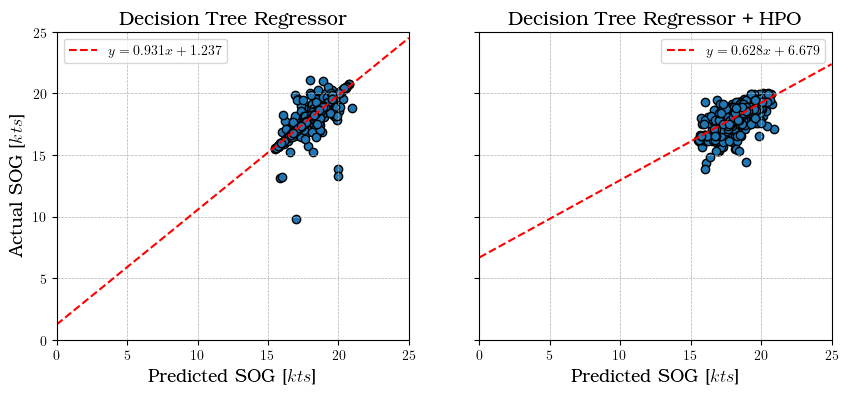

In [384]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_dtr_ftr,'Decision Tree Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_dtr_hpov,'Decision Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

0.8193098379889877
y = 0.8 * x + 3.7
0.8236280233687441
y = 0.8 * x + 3.7


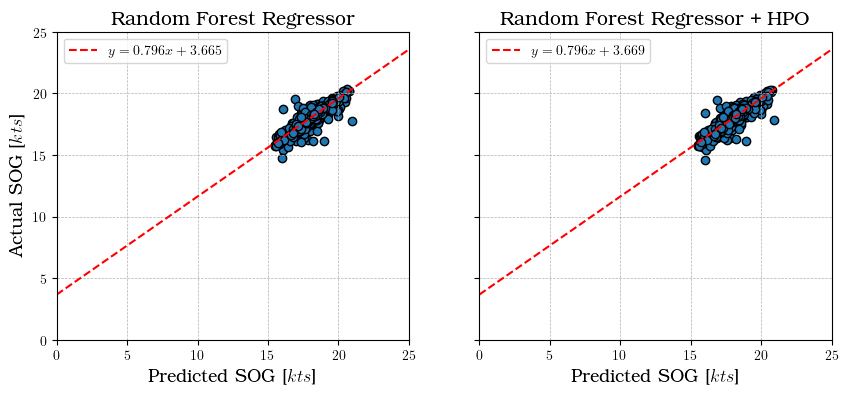

In [385]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_rfr_ftr,'Random Forest Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_rfr_hpov,'Random Forest Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

0.9046869082459551
y = 0.9 * x + 1.2
0.8045193524923904
y = 0.8 * x + 3.9


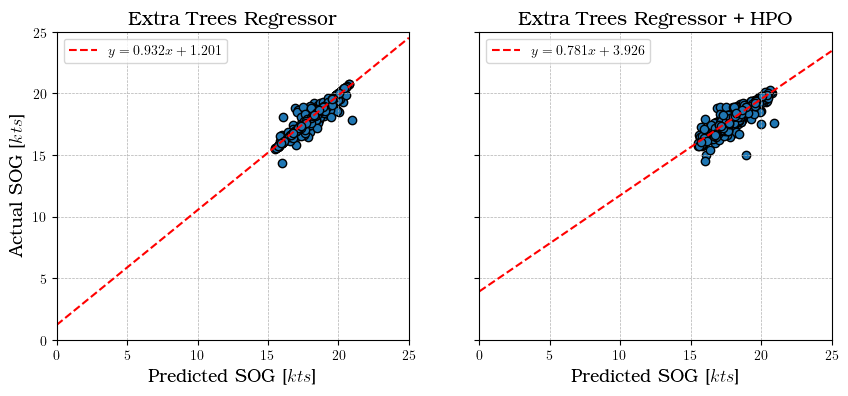

In [386]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_etr,'Extra Trees Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_etr_hpov,'Extra Trees Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

Evaluation using Cross Validation

In [387]:
# scores_test = [r2_rf,r2_et,r2_dt,r2_mlr]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# # ax = fig.add_axes([0, 0, 1, 1])
# fig,ax = plt.subplots()
# plt.title("Validation Data Model Performance")
# plt.ylabel("R-squared")
# plt.xlabel("Model")
# plt.yscale('linear')
# plt.ylim(0.2,1.0)
# plt.boxplot(scores_test,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels(['RFR', 'ETR',
#                     'DTR','MLR'])
# plt.show()

In [388]:
# scores_test = [-RMSE_rf,-RMSE_et,-RMSE_dt,-RMSE_mlr]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# # ax = fig.add_axes([0, 0, 1, 1])
# fig,ax = plt.subplots()
# plt.title("Validation Data Model Performance")
# plt.ylabel("RMSE")
# plt.xlabel("Model")
# plt.yscale('linear')
# plt.ylim(0,1.6)
# plt.boxplot(scores_test,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels(['RFR', 'ETR',
#                     'DTR','MLR'])
# plt.show()

Optimization comparison

In [389]:
# scores_opt = [r2_rfo_s,r2_rfo_w,r2_eto_s,r2_eto_w,r2_dto_s,r2_dto_w]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Optimized Model on Test Dataset Performance")
# plt.ylabel("R-squared")
# plt.xlabel("Model")
# plt.ylim(0.2,1.0)
# plt.yscale('linear')
# ax.boxplot(scores_opt,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels([r'$RFR_{sum}$', r'$RFR_{win}$',
#                     r'$ETR_{sum}$', r'$ETR_{win}$',
#                     r'$DTR_{sum}$',r'$DTR_{win}$'])
# plt.show()

In [390]:
# rmse_opt = [RMSE_rfo_s,RMSE_rfo_w,RMSE_eto_s,RMSE_eto_w,RMSE_dto_s,RMSE_dto_w]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Optimized Model Performance")
# plt.ylabel("RMSE")
# plt.xlabel("Model")
# plt.yscale('linear')
# plt.ylim(0,2)
# ax.boxplot(rmse_opt,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels([r'$RFR_{sum}$', r'$RFR_{win}$',
#                     r'$ETR_{sum}$', r'$ETR_{win}$',
#                     r'$DTR_{sum}$',r'$DTR_{win}$'])
# plt.show()

In [391]:
# scores_opt = [r2_rf,r2_rfc,r2_et,r2_etc,r2_dt,r2_dtc]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Impact of amount of data")
# plt.ylabel("R-squared")
# plt.xlabel("Model")
# plt.ylim(0.2,1.0)
# plt.yscale('linear')
# ax.boxplot(scores_opt,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels([r'RFR', r'$RFR_{6mths}$',
#                     r'ETR', r'$ETR_{6mths}$',
#                     r'DTR',r'$DTR_{6mths}$'])
# plt.show()

In [392]:
# rmse_opt = [-RMSE_rf,-RMSE_rfc,-RMSE_et,-RMSE_etc,-RMSE_dt,-RMSE_dtc]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Impact of Amount of Data")
# plt.ylabel("RMSE")
# plt.xlabel("Model")
# plt.yscale('linear')
# plt.ylim(0,1.6)
# ax.boxplot(rmse_opt,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels([r'RFR', r'$RFR_{6mths}$',
#                     r'ETR', r'$ETR_{6mths}$',
#                     r'DTR',r'$DTR_{6mths}$'])
# plt.show()

In [393]:
# # define the true objective function
# def objective(x, a, b, c):
# 	return a * x + b * x**2 + c

STW Calculation

In [394]:
def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

#Test data

# ETR
ydate_pred_s = label_predict(model_etr_hpov,x_date_s)
ydate_pred_w = label_predict(model_etr_hpov,x_date_w)
ydate_pred_yr = label_predict(model_etr_hpov,x_date_yr)

# RFR
ydate_pred_rf_s = label_predict(model_rfr_hpov,x_date_s)
ydate_pred_rf_w = label_predict(model_rfr_hpov,x_date_w)
ydate_pred_rf_yr = label_predict(model_rfr_hpov,x_date_yr)


# DTR
ydate_pred_dt_s = label_predict(model_dtr_hpov,x_date_s)
ydate_pred_dt_w = label_predict(model_dtr_hpov,x_date_w)
ydate_pred_dt_yr = label_predict(model_dtr_hpov,x_date_yr)

# MLR  
ydate_pred_mlr_s = label_predict(model_mlr_ftr,x_date_s)
ydate_pred_mlr_w = label_predict(model_mlr_ftr,x_date_w)
ydate_pred__mlr_yr = label_predict(model_mlr_ftr,x_date_yr)


# For actual results

# Yearly dataset

dfprog_sog_yr = pd.Series(y_date_yr,name="sog_act_yr").to_frame()
ydate_pred_yr = label_predict(model_etr_hpov,x_date_yr)
ydate_pred_rf_yr = label_predict(model_rfr_hpov,x_date_yr)
ydate_pred_dt_yr = label_predict(model_dtr_hpov,x_date_yr)
ydate_pred_mlr_yr = label_predict(model_mlr_ftr,x_date_yr)
dfprog_sog_yr["sog_pred_yr"] = ydate_pred_yr
dfprog_sog_yr["sog_pred_rf_yr"] = ydate_pred_rf_yr
dfprog_sog_yr["sog_pred_dt_yr"] = ydate_pred_dt_yr
dfprog_sog_yr["sog_pred_mlr_yr"] = ydate_pred_mlr_yr
dfprog_sog_yr["gamma_yr"] = df_year_tr["truenorthcurrentdir"]
dfprog_sog_yr["nwinddir_yr"] = df_year_tr["truenorthwinddir"]
dfprog_yr = pd.concat([x_date_yr,dfprog_sog_yr],axis=1)


# Winter dataset
dfprog_sog_w = pd.Series(y_date_w,name="sog_act_w").to_frame()
ydate_pred_w = label_predict(model_etr_hpov,x_date_w)
ydate_pred_rf_w = label_predict(model_rfr_hpov,x_date_w)
ydate_pred_dt_w = label_predict(model_dtr_hpov,x_date_w)
ydate_pred_mlr_w = label_predict(model_mlr_ftr,x_date_w)
dfprog_sog_w["sog_pred_w"] = ydate_pred_w
dfprog_sog_w["sog_pred_rf_w"] = ydate_pred_rf_w
dfprog_sog_w["sog_pred_dt_w"] = ydate_pred_dt_w
dfprog_sog_w["sog_pred_mlr_w"] = ydate_pred_mlr_w
dfprog_sog_w["gamma_w"] = df_winter_tr["truenorthcurrentdir"]
dfprog_sog_w["nwinddir_w"] = df_winter_tr["truenorthwinddir"]
dfprog_w = pd.concat([x_date_w,dfprog_sog_w],axis=1)

# Summer Dataset
dfprog_sog_s = pd.Series(y_date_s,name="sog_act_s").to_frame()
ydate_pred_s = label_predict(model_etr_hpov,x_date_s)
ydate_pred_rf_s = label_predict(model_rfr_hpov,x_date_s)
ydate_pred_dt_s = label_predict(model_dtr_hpov,x_date_s)
ydate_pred_mlr_s = label_predict(model_mlr_ftr,x_date_s)
dfprog_sog_s["sog_pred_s"] = ydate_pred_s
dfprog_sog_s["sog_pred_rf_s"] = ydate_pred_rf_s
dfprog_sog_s["sog_pred_dt_s"] = ydate_pred_dt_s
dfprog_sog_s["sog_pred_mlr_s"] = ydate_pred_mlr_s
dfprog_sog_s["gamma_s"] = df_summer_tr["truenorthcurrentdir"]
dfprog_sog_s["nwinddir_s"] = df_summer_tr["truenorthwinddir"]
dfprog_s = pd.concat([x_date_s,dfprog_sog_s],axis=1)




# dfprog_sog = pd.Series(y_date_s,name="sog_act_s").to_frame()
# dfprog_sog["sog_act_w"] = y_date_w
# #ETR
# dfprog_sog["sog_pred_s"] = ydate_pred_s
# dfprog_sog["sog_pred_w"] = ydate_pred_w
# #RFR
# dfprog_sog["sog_pred_rf_s"] = ydate_pred_rf_s
# dfprog_sog["sog_pred_rf_w"] = ydate_pred_rf_w
# #DTR
# dfprog_sog["sog_pred_dt_s"] = ydate_pred_dt_s
# dfprog_sog["sog_pred_dt_s"] = ydate_pred_dt_s
# #MLR one year
# dfprog_sog["sog_pred_mlr"] = ydate_pred_mlr
# #Current wind direction summer winter
# dfprog_sog["gamma_s"] = df_summer_tr["truenorthcurrentdir"]
# dfprog_sog["gamma_w"] = df_winter_tr["truenorthcurrentdir"]
# dfprog_sog["nwinddir_s"] = df_summer_tr["truenorthwinddir"]
# dfprog_sog["nwinddir_s"] = df_summer_tr["truenorthwinddir"]

# dfprog = pd.concat([x_date,dfprog_sog],axis=1)
# print(dfprog_sog)

In [395]:
dfprog_yr.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act_yr,sog_pred_yr,sog_pred_rf_yr,sog_pred_dt_yr,sog_pred_mlr_yr,gamma_yr,nwinddir_yr
count,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000
mean,282.521096,3.673747,283.252584,0.755916,5.233213,200.016135,197.948902,6.559270,0.100408,89.193632,91.012446,90.511605,18.173585,18.110677,18.128985,18.088599,17.692054,148.153034,197.342340
std,6.437256,0.861528,5.749356,0.518801,0.177176,89.588185,89.244511,2.984239,0.069135,56.073901,57.842459,56.509129,1.039384,0.901835,0.909569,0.935649,0.500114,101.578774,90.829671
min,267.095032,1.672565,273.685059,0.075465,4.742517,69.768055,67.902386,0.398818,0.003022,0.134469,0.261234,0.200645,15.512127,14.529552,14.561708,13.864252,14.995880,0.172301,0.232451
25%,276.994385,3.001080,277.983673,0.361698,5.110946,100.866831,99.761126,4.274962,0.051704,35.900782,38.079257,36.217798,17.564763,17.617856,17.624093,17.493749,17.429074,71.822843,139.472374
50%,281.952637,3.586478,282.756714,0.626795,5.288063,273.604968,271.532933,6.471532,0.080828,89.391535,89.815770,88.335343,18.222930,18.229462,18.215999,18.366859,17.732591,119.500471,204.717196
75%,288.729340,4.263344,288.714355,1.026444,5.377520,283.020862,280.379787,8.475245,0.132449,141.618781,145.791478,144.809243,18.843612,18.758373,18.780688,18.779032,18.023982,218.434873,274.637991
max,295.699951,6.680546,294.928223,2.756067,5.658523,305.989862,305.179356,15.423022,0.497666,179.858625,179.820002,179.918071,20.935741,20.301575,20.298990,19.996240,19.162222,359.264290,358.907188


In [396]:
dfprog_w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406 entries, 7509 to 2728
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     406 non-null    float64
 1   waveperiod           406 non-null    float64
 2   surftemp             406 non-null    float64
 3   windwaveswellheight  406 non-null    float64
 4   draught              406 non-null    float64
 5   cog                  406 non-null    float64
 6   heading              406 non-null    float64
 7   windspeed            406 non-null    float64
 8   curspeed             406 non-null    float64
 9   truewinddir          406 non-null    float64
 10  truecurrentdir       406 non-null    float64
 11  truewavedir          406 non-null    float64
 12  sog_act_w            406 non-null    float64
 13  sog_pred_w           406 non-null    float64
 14  sog_pred_rf_w        406 non-null    float64
 15  sog_pred_dt_w        406 non-null   

In [397]:
dfprog_w.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act_w,sog_pred_w,sog_pred_rf_w,sog_pred_dt_w,sog_pred_mlr_w,gamma_w,nwinddir_w
count,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000
mean,279.211044,3.733797,280.186577,0.775273,5.177197,199.024194,197.217204,6.730687,0.102562,86.978001,98.108861,92.469053,18.039892,18.036156,18.044297,18.059422,17.633612,149.626926,205.365358
std,4.952724,0.780558,4.457583,0.473591,0.177812,89.617155,89.480575,2.813988,0.065985,55.226737,55.459410,53.812617,0.916055,0.794736,0.805201,0.836302,0.502336,100.132305,93.326017
min,267.095032,1.672565,273.685059,0.075465,4.742517,94.003950,89.221494,0.427826,0.003022,0.134469,0.554401,0.464269,15.512127,15.017905,15.391915,14.371104,15.468972,0.172301,0.232451
25%,276.021851,3.184935,277.176636,0.411536,5.026177,100.657039,99.545819,4.495645,0.053173,34.480850,45.033128,42.969736,17.515754,17.632515,17.625918,17.493749,17.319267,74.601322,156.736613
50%,278.197998,3.652972,278.673889,0.671879,5.199724,273.592920,271.532933,6.657582,0.088244,85.257275,102.099316,94.352773,18.117192,18.127481,18.131007,18.159884,17.650369,120.773114,209.093121
75%,280.745361,4.279978,282.513306,1.043923,5.290249,283.247224,280.764497,8.716621,0.136914,136.758689,149.515594,141.587718,18.658240,18.611110,18.666593,18.664988,17.986690,215.617778,279.892393
max,292.686035,5.741870,292.428223,2.641841,5.555485,305.989862,305.179356,14.498614,0.364092,179.858625,179.820002,179.070676,20.344055,19.722022,19.812739,19.977031,19.162222,359.264290,358.907188


In [398]:
dfprog_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 382 entries, 3198 to 6820
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     382 non-null    float64
 1   waveperiod           382 non-null    float64
 2   surftemp             382 non-null    float64
 3   windwaveswellheight  382 non-null    float64
 4   draught              382 non-null    float64
 5   cog                  382 non-null    float64
 6   heading              382 non-null    float64
 7   windspeed            382 non-null    float64
 8   curspeed             382 non-null    float64
 9   truewinddir          382 non-null    float64
 10  truecurrentdir       382 non-null    float64
 11  truewavedir          382 non-null    float64
 12  sog_act_s            382 non-null    float64
 13  sog_pred_s           382 non-null    float64
 14  sog_pred_rf_s        382 non-null    float64
 15  sog_pred_dt_s        382 non-null   

In [399]:
dfprog_s.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act_s,sog_pred_s,sog_pred_rf_s,sog_pred_dt_s,sog_pred_mlr_s,gamma_s,nwinddir_s
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,286.039109,3.609926,286.511220,0.735343,5.292749,201.070397,198.726570,6.377085,0.098119,91.548465,83.470183,88.431177,18.315678,18.189880,18.218993,18.119609,17.754168,146.586541,188.815257
std,5.952871,0.936796,5.147199,0.562787,0.155999,89.662852,89.103658,3.148621,0.072349,56.938332,59.420914,59.240725,1.140272,0.998189,1.001979,1.031015,0.490810,103.202239,87.415752
min,269.218018,2.006727,274.747070,0.099744,4.748948,69.768055,67.902386,0.398818,0.007685,0.427861,0.261234,0.200645,15.532541,14.529552,14.561708,13.864252,14.995880,3.117300,1.305558
25%,283.330444,2.853830,283.124207,0.330512,5.199738,101.446594,99.928632,4.134336,0.048138,37.668581,25.351309,29.155265,17.619059,17.604218,17.616724,17.493749,17.532365,69.469908,122.299646
50%,287.439697,3.481118,287.731689,0.574301,5.290621,273.632539,271.545127,6.001820,0.076443,96.994073,70.221749,82.689301,18.398417,18.417695,18.392744,18.366859,17.808585,115.846038,196.615758
75%,290.573608,4.219124,290.305908,0.986234,5.380782,282.779683,279.553335,8.305133,0.127318,144.886990,143.545146,148.952687,19.201413,18.932252,18.939979,18.907098,18.033517,220.988745,258.972751
max,295.699951,6.680546,294.928223,2.756067,5.658523,305.416681,303.295177,15.423022,0.497666,179.451878,179.074917,179.918071,20.935741,20.301575,20.298990,19.996240,18.958862,358.829646,357.719936


In [400]:
print(dfprog_sog_s.describe())
print(dfprog_sog_s.describe().transpose().to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,

))  

        sog_act_s  sog_pred_s  sog_pred_rf_s  sog_pred_dt_s  sog_pred_mlr_s  \
count  382.000000  382.000000     382.000000     382.000000      382.000000   
mean    18.315678   18.189880      18.218993      18.119609       17.754168   
std      1.140272    0.998189       1.001979       1.031015        0.490810   
min     15.532541   14.529552      14.561708      13.864252       14.995880   
25%     17.619059   17.604218      17.616724      17.493749       17.532365   
50%     18.398417   18.417695      18.392744      18.366859       17.808585   
75%     19.201413   18.932252      18.939979      18.907098       18.033517   
max     20.935741   20.301575      20.298990      19.996240       18.958862   

          gamma_s  nwinddir_s  
count  382.000000  382.000000  
mean   146.586541  188.815257  
std    103.202239   87.415752  
min      3.117300    1.305558  
25%     69.469908  122.299646  
50%    115.846038  196.615758  
75%    220.988745  258.972751  
max    358.829646  357.719936  


C:\Users\Wafi\AppData\Local\Temp\ipykernel_16904\2514083402.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dfprog_sog_s.describe().transpose().to_latex(index=False,


<Figure size 500x300 with 0 Axes>

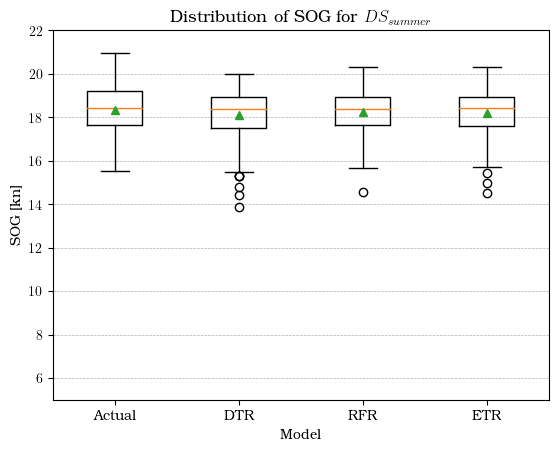

In [401]:
# Box plot of predicted results of winter dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_s['sog_act_s'],dfprog_sog_s['sog_pred_dt_s'],dfprog_sog_s['sog_pred_rf_s'],dfprog_sog_s['sog_pred_s']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{summer}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

In [402]:
print(dfprog_sog_w.describe())
print(dfprog_sog_w.describe().transpose().to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,

)) 

        sog_act_w  sog_pred_w  sog_pred_rf_w  sog_pred_dt_w  sog_pred_mlr_w  \
count  406.000000  406.000000     406.000000     406.000000      406.000000   
mean    18.039892   18.036156      18.044297      18.059422       17.633612   
std      0.916055    0.794736       0.805201       0.836302        0.502336   
min     15.512127   15.017905      15.391915      14.371104       15.468972   
25%     17.515754   17.632515      17.625918      17.493749       17.319267   
50%     18.117192   18.127481      18.131007      18.159884       17.650369   
75%     18.658240   18.611110      18.666593      18.664988       17.986690   
max     20.344055   19.722022      19.812739      19.977031       19.162222   

          gamma_w  nwinddir_w  
count  406.000000  406.000000  
mean   149.626926  205.365358  
std    100.132305   93.326017  
min      0.172301    0.232451  
25%     74.601322  156.736613  
50%    120.773114  209.093121  
75%    215.617778  279.892393  
max    359.264290  358.907188  


C:\Users\Wafi\AppData\Local\Temp\ipykernel_16904\3151661830.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dfprog_sog_w.describe().transpose().to_latex(index=False,


<Figure size 500x300 with 0 Axes>

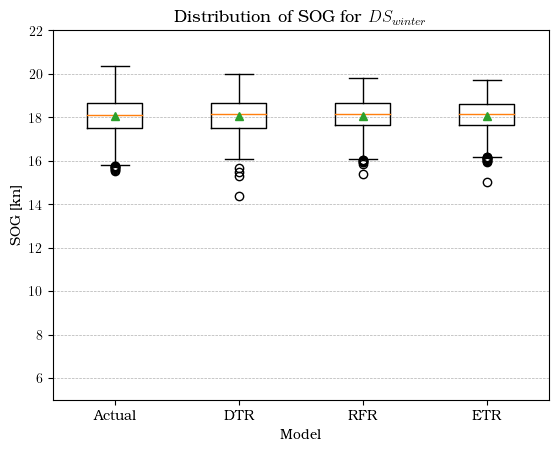

In [403]:
# Box plot of predicted results of winter dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_w['sog_act_w'],dfprog_sog_w['sog_pred_dt_w'],dfprog_sog_w['sog_pred_rf_w'],dfprog_sog_w['sog_pred_w']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{winter}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

In [404]:
print(dfprog_sog_yr.describe())
print(dfprog_sog_yr.describe().transpose().to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,

)) 

       sog_act_yr  sog_pred_yr  sog_pred_rf_yr  sog_pred_dt_yr  \
count  788.000000   788.000000      788.000000      788.000000   
mean    18.173585    18.110677       18.128985       18.088599   
std      1.039384     0.901835        0.909569        0.935649   
min     15.512127    14.529552       14.561708       13.864252   
25%     17.564763    17.617856       17.624093       17.493749   
50%     18.222930    18.229462       18.215999       18.366859   
75%     18.843612    18.758373       18.780688       18.779032   
max     20.935741    20.301575       20.298990       19.996240   

       sog_pred_mlr_yr    gamma_yr  nwinddir_yr  
count       788.000000  788.000000   788.000000  
mean         17.692054  148.153034   197.342340  
std           0.500114  101.578774    90.829671  
min          14.995880    0.172301     0.232451  
25%          17.429074   71.822843   139.472374  
50%          17.732591  119.500471   204.717196  
75%          18.023982  218.434873   274.637991  
max  

C:\Users\Wafi\AppData\Local\Temp\ipykernel_16904\2854589879.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dfprog_sog_yr.describe().transpose().to_latex(index=False,


<Figure size 500x300 with 0 Axes>

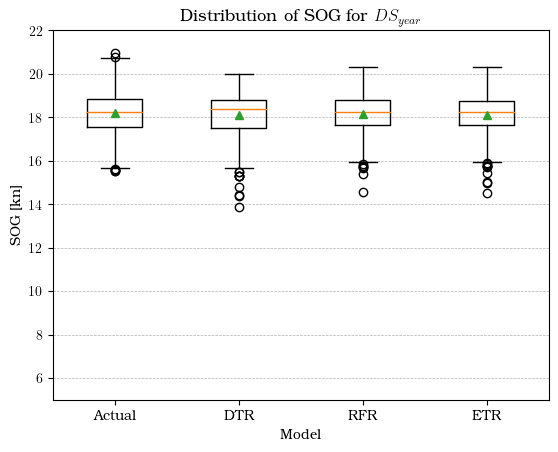

In [405]:
# Box plot of predicted results of yearly dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_yr['sog_act_yr'],dfprog_sog_yr['sog_pred_dt_yr'],dfprog_sog_yr['sog_pred_rf_yr'],dfprog_sog_yr['sog_pred_yr']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{year}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

In [406]:
def sog_corr(sog,gamma,heading,current_speed):
    # Conversion of predicted SOG to m/s
    vgms = sog/1.9438
    rad_gamma = np.deg2rad(gamma)
    rad_cog = np.deg2rad(heading)
    # Calculation of the predicted x-component of SOG

    vgx = vgms * np.sin(rad_cog)
    vcx = current_speed * np.sin(rad_gamma)
    stw_x = vgx - vcx

    # Calculation of the predicted y-component of SOG 

    vgy = vgms * np.cos(rad_cog)
    vcy = current_speed * rad_gamma
    stw_y = vgy - vcy

    vwms_p = np.sqrt(stw_x**2 + stw_y**2)
    stw_pred = vwms_p*1.9438

    return stw_pred

In [407]:
# STW conversion Year

# Actual
stw_act_yr = sog_corr(dfprog_yr['sog_act_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_act_yr'] = stw_act_yr
# ETR
stw_pred_et_yr = sog_corr(dfprog_yr['sog_pred_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_yr'] = stw_pred_et_yr
# RFR
stw_pred_rf_yr = sog_corr(dfprog_yr['sog_pred_rf_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_rf_yr'] = stw_pred_rf_yr
# DTR
stw_pred_dt_yr = sog_corr(dfprog_yr['sog_pred_dt_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_dt_yr'] = stw_pred_dt_yr
# MLR
stw_pred_mlr_yr = sog_corr(dfprog_yr['sog_pred_mlr_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_mlr_yr'] = stw_pred_mlr_yr



In [408]:
print(dfprog_yr.describe())

       oceantemperature  waveperiod    surftemp  windwaveswellheight  \
count        788.000000  788.000000  788.000000           788.000000   
mean         282.521096    3.673747  283.252584             0.755916   
std            6.437256    0.861528    5.749356             0.518801   
min          267.095032    1.672565  273.685059             0.075465   
25%          276.994385    3.001080  277.983673             0.361698   
50%          281.952637    3.586478  282.756714             0.626795   
75%          288.729340    4.263344  288.714355             1.026444   
max          295.699951    6.680546  294.928223             2.756067   

          draught         cog     heading   windspeed    curspeed  \
count  788.000000  788.000000  788.000000  788.000000  788.000000   
mean     5.233213  200.016135  197.948902    6.559270    0.100408   
std      0.177176   89.588185   89.244511    2.984239    0.069135   
min      4.742517   69.768055   67.902386    0.398818    0.003022   
25%   

In [409]:
# STW conversion Summer 

# Actual
stw_act_s = sog_corr(dfprog_s['sog_act_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_act_s'] = stw_act_s
# ETR
stw_pred_et_s = sog_corr(dfprog_s['sog_pred_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_s'] = stw_pred_et_s
# RFR
stw_pred_rf_s = sog_corr(dfprog_s['sog_pred_rf_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_rf_s'] = stw_pred_rf_s
# DTR
stw_pred_dt_s = sog_corr(dfprog_s['sog_pred_dt_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_dt_s'] = stw_pred_dt_s
# MLR
stw_pred_mlr_s = sog_corr(dfprog_s['sog_pred_mlr_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_mlr_s'] = stw_pred_mlr_s



In [410]:
print(dfprog_s.describe())

       oceantemperature  waveperiod    surftemp  windwaveswellheight  \
count        382.000000  382.000000  382.000000           382.000000   
mean         286.039109    3.609926  286.511220             0.735343   
std            5.952871    0.936796    5.147199             0.562787   
min          269.218018    2.006727  274.747070             0.099744   
25%          283.330444    2.853830  283.124207             0.330512   
50%          287.439697    3.481118  287.731689             0.574301   
75%          290.573608    4.219124  290.305908             0.986234   
max          295.699951    6.680546  294.928223             2.756067   

          draught         cog     heading   windspeed    curspeed  \
count  382.000000  382.000000  382.000000  382.000000  382.000000   
mean     5.292749  201.070397  198.726570    6.377085    0.098119   
std      0.155999   89.662852   89.103658    3.148621    0.072349   
min      4.748948   69.768055   67.902386    0.398818    0.007685   
25%   

In [411]:
# STW conversion Winter

# Actual
stw_act_w = sog_corr(dfprog_w['sog_act_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_act_w'] = stw_act_w
# ETR
stw_pred_et_w = sog_corr(dfprog_w['sog_pred_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_w'] = stw_pred_et_w
# RFR
stw_pred_rf_w = sog_corr(dfprog_w['sog_pred_rf_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_rf_w'] = stw_pred_rf_w
# DTR
stw_pred_dt_w = sog_corr(dfprog_w['sog_pred_dt_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_dt_w'] = stw_pred_dt_w
# MLR
stw_pred_mlr_w = sog_corr(dfprog_w['sog_pred_mlr_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_mlr_w'] = stw_pred_mlr_w

In [412]:
# # Predicted SOG from RF model

# stw_pred_rf = sog_corr(dfprog_sog['sog_pred_rf'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

# dfprog['stw_pred_rf'] = stw_pred_rf

In [413]:
# # Predicted SOG from DT model

# stw_pred_dt = sog_corr(dfprog_sog['sog_pred_dt'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

# dfprog['stw_pred_dt'] = stw_pred_dt

In [414]:
# # Predicted SOG from MLR model

# stw_pred_mlr = sog_corr(dfprog_sog['sog_pred_mlr'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

# dfprog['stw_pred_mlr'] = stw_pred_mlr

In [415]:
# # Actual SOG

# stw_pred_act = sog_corr(dfprog_sog['sog_act'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

# dfprog['stw_act'] = stw_pred_act

In [416]:
# dfprog.describe()

Holtrop Mennen FOC function

In [417]:
def foc_fun(stw,T_dyn,windspeed,truewindir,H_s,truewavedir):
    # Ship Information, that are readily available in ship specification
    loa = 158 # ship overall length
    lwl = 144.8 # ship waterline length, m
    lpp = 0.97*lwl # ship perpendicular length , m, according to information
    B = 24.5 # Ship breadth, m
    depth = 13.8 # Ship depth. m
    T_n = 5.85 # Nominal max draught , m
    # T_n = 5.7 # Nominal design draught , m
    dwt = 5110 # ship dead weight , t
    V_n = 17.7 # ship design speed, knots
    # V_n = 18 # ship design speed, knots


    # Environmental Constants

    g = 9.805 # gravity, kg/ms^2 
    rho_sea = 1025 # kg/m3
    nu_sea = 0.00000118 # Dynamic viscosity of sea m^2/s
    rho_air = 1.25 # density air 

    # Any other additional ship parameters beyond here are approximated based on literature review.

    # Convert STW to m/s, stw with only current correction

    stw_ms = stw / 1.94384

    # Switch between actual and predicted here 
    # Calculation for Block coefficient,C_b, according to Schneekluth and Bertram 1998
    # Then Froude number is required

    V_n = 17.7/1.94384
    # V_n = 18/1.94384

    Fr_n = V_n / math.sqrt(g*lwl)
    # print(f"Froude Number {Fr_n:0.4f}")

    C_b = -4.22 + 27.8*math.sqrt(Fr_n) - 39.1*Fr_n + 46.6*(Fr_n)**3
    # print(f"C_b {C_b:0.4f}")

    # calculation for midship section coefficient, C_m according to Jensen from Birk

    C_m = 1 / (1+(1-C_b)**3.5)
    # print(f"C_m {C_m:0.4f}")

    # prismatic coefficient C_p can be calculated according to Biran

    C_p = C_b/C_m 
    # print(f"C_p {C_p:0.4f}")

    # Displacement calculation according to Barras 

    dsp = C_b * lwl * B * T_n

    # print(f"dsp {dsp:0.4f} m^3")

    # coefficient c14 to account for stern shape according to holtrop mennen

    C_stern = 10 # assume u shaped stern
    c14 = 1 + 0.011*C_stern 
    
    # print(f"c14 {c14:0.4f}")

    # Calculate length of run according to holtrop mennen

    # lcb = -2/100 # according to Barras
    lcb = -(0.44*Fr_n - 0.094) # according to Guldhammer and Harvald

    # print(f"lcb {lcb:0.4f}")

    # L in holtrop mennen is lwl

    lr = lwl*(1-C_p+(0.06*C_p*lcb/(4*C_p-1)))

    # print(f"lr {lr:0.4f} m")

    # now the (1+k1) can be calculated

    k1a = 0.487118*c14*(B/lwl)**1.06806
    k1b = (T_dyn/lwl)**0.46106
    k1c = (lwl/lr)**0.121563
    k1d = (lwl**3/dsp)**0.36486
    k1e = (1-C_p)**-0.604247

    k1_const = 0.93 + k1a*k1b*k1c*k1d*k1e

    # print(f"k1_const {k1_const.mean():0.4f}")

    # Calculate Reynold number and Coefficient of Friction C_f. Here, the C_f will be dynamic and depend on the velocity of the ship

    Re =( stw_ms * lwl ) / nu_sea
    C_f = 0.075 / (np.log10(Re-2)**2)

    # print(f"Mean Reynold Number {Re.mean():0.2f}")
    # print(f"Mean Coefficient of friction {C_f.mean():0.6f}")
    
    # Calculate the appendage area of bare hull S_bh
    # Formula according to Holtrop Mennen

    # Calculate the waterplane area coefficient 
    # Formula according to Schneekluth and Bertram

    C_wp = (1+2*C_b)/3
    # print(f"C_wp {C_wp:0.4f}")

    # Calculate transverse bulb area A_bt, Transom area A_t and immersed midship section area A_m according to Kim 2019

    # dfprog['A_m'] = B*dfprog['draught']*C_m
    # Borrow estimation of Am from Guldahmmer and Harvald
    A_m = dsp/(lpp*C_p)
    A_t = 0.051 * A_m
    A_bt = 0.085*A_m # From approximation of Kracht78, Similar to Charcalis
    # print(f"A_m {A_m:0.2f} m^2")
    # print(f"A_t {A_t:0.4f} m^2")
    # print(f"A_bt {A_bt:0.4f} m^2")

    sbh_a = lwl*(2*T_dyn+B)*math.sqrt(C_m)
    sbh_b = 0.453
    sbh_c = 0.4425*C_b
    sbh_d = 0.2862*C_m
    sbh_e = 0.003467*(B/T_dyn)
    sbh_f = 0.3696*C_wp
    sbh_g = 2.38*A_bt/C_b

    S_bh = sbh_a*(sbh_b+sbh_c-sbh_d+sbh_e+sbh_f)+sbh_g

    # print(f"S_bh {S_bh.mean():0.4f} m^2")

    # Calculate R_f

    R_f = 0.5 * rho_sea * stw_ms**2 * C_f * S_bh * k1_const

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Frictional Resistance {R_f.mean():0.2f} N")
    
    # Calculate resistance due to appendage

    # Assume S_app
    # Taken from Holtrop Mennen worked example
    # S_app = 50 # m^2 

    # Calculation of appendage area according to Hollenbach method, the formula is for twin screw ship

    # Lower limit
    S_app_lo = S_bh.mean()*(0.028+0.01*math.exp(-(lpp*T_n)/1000))

    # Upper limit
    S_app_hi = S_bh.mean()*(0.0325+0.045*math.exp(-(lpp*T_n)/1000))

    # print(f"S_app between {S_app_lo:.02f} and {S_app_hi:.02f} according to Hollenbach")

    # The following appendage area are scaled from the picture of the ship
    # Constant k here means (1+k_2) !

    D_shaft = 0.55 # m, approx
    l_shaft = 13.54 # m, approx

    S_app_shaft = 2*math.pi * D_shaft * l_shaft
    k2_shaft = 3   

    h_rudder = 4.06 #m, approx
    B_rudder = 1.99 #m, approx
    S_app_rudder = 2 * h_rudder * B_rudder #m, two side
    k2_rudder = 3

    h_skeg = 4.41 #m, approx
    l_skeg = 26.23 #m, approx
    S_app_skeg =  h_skeg * l_skeg #two side (triangle)
    k2_skeg = 1.5

    S_app = S_app_shaft + S_app_rudder + S_app_skeg

    k2_const = (k2_shaft*S_app_shaft + k2_rudder*S_app_rudder + k2_skeg*S_app_skeg)/S_app

    # print(f"Wetted area of hull is {S_bh.mean():0.2f}")
    # print(f"(1+k2) equivalent {k2_const:0.2f}")
    # print(f"Total Appendage area is {S_app:0.4f}")
    # # from holtrop mennen, take case of twin screw
    # k2_const = 2.8

    # Add resistance due to Bow Thrusters

    d_th = 2.15 #m, approx

    # Use formula from Hollenach
    C_dth = 0.003 + 0.003*((10*d_th/T_n)-1)
    # C_dth = 0.003 # The picture shows that the thruster are fairly parallel to midship area
    # There are two bow thruster in this ship
    R_th = rho_sea*stw_ms**2*math.pi*d_th**2*C_dth

    # print(f"Friction due to bow thrusters {R_th.mean():0.2f} N")

    R_app = (0.5 * rho_sea * stw_ms**2 * C_f * S_app *k2_const) + 2*R_th

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Appendage Friction {R_app.mean():0.2f} N")

    # Calculate wave-making and wave-breaking resistance

    # print("Ratio check to ensure correct formula is used for Holtrop Mennen")
    # print(f"B/lwl = {B/lwl:0.2f}")
    # print(f"lwl^3/displacemt = {lwl**3/dsp:0.2f}")
    # print(f"C_p = {C_p:0.4f}")


    c7 = B/lwl
    T_fwd = T_dyn # See reasoning from Rakke16 
    h_b = 0.6*T_n # must not exceed 0.6 T_f, here T_n = T_f (design), reasong and coefficient value taken from Rakke
    
    # print(f"h_B {h_b:0.4f}")

    # All formulas here are listed by Holtrop Mennen

    c3 = 0.56 * A_bt**1.5 / (B*T_dyn*(0.31*np.sqrt(A_bt)+T_fwd-h_b))
    c2 = np.exp(-1.89*np.sqrt(c3))
    c5 = 1 - 0.8*(A_t/(B*T_dyn*C_m))
    lambda_const = (1.446 * C_p) - 0.03*(lwl/B)
    c16 = 8.07981*C_p - 13.8673*C_p**2 + 6.984388*C_p**3
    m_1 = 0.0140407 * (lwl/T_dyn) - 1.75254*(dsp**(1/3)/lwl) -  4.79323*(B/lwl) - c16
    c15 = -1.69385

    # Use dynamic Froude here to refect the actual resistance due to ship movement 

    Fr_n_dyn = stw_ms / math.sqrt(g*lwl)
    # Updated formula use m_4
    m4 = 0.4 * c15 * np.exp(-0.034*Fr_n_dyn **-3.29)

    i_e = 1 + 89*math.exp(-(lwl/B)**0.80856*(1-C_wp)**0.30484*(1-C_p-0.0225*lcb)**0.6367*(lr/B)**0.34574*((100*dsp)/lwl**3)**0.16302)
    c1 = 2223105 * c7**3.78613 * (T_dyn/B)**1.07961*(90-i_e)**-1.37565
    d = -0.9

    # print(f"i_e = {i_e:0.4f}")

    # Use updated formula with m4

    R_w = c1*c2*c5*dsp*g*rho_sea*np.exp(m_1*Fr_n_dyn **d+m4*np.cos(lambda_const*Fr_n_dyn **-2))

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Wave resistance {R_w.mean():0.2f} N")

    # Calculate Resistance due to Bulbous Bow
    # Calculate effect of forward sinkage h_f and local wave height at bow h_w

    P_b = 0.56*np.sqrt(A_bt)/(T_fwd-1.5*h_b)
    Fn_i = stw_ms / np.sqrt(g*(T_fwd-h_b-0.25*np.sqrt(A_bt))+0.15*stw_ms**2)
    R_b = 0.11 * np.exp(-3*P_b**-2)*Fn_i**3*A_bt**1.5*rho_sea*g/(1+Fn_i**2)

    # print(f"Emergence of bulb Pb {P_b.mean():0.4f}")
    # print(f"Immersion Froude number Fn_i {Fn_i.mean():0.2f}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Resistance due to bulbous bow {R_b.mean():0.2f} N")    

    #Calculate Transom Resistance 

    Fn_tr = stw_ms / np.sqrt(2*g*A_t/(B+(B*C_wp)))

    # print(f"Froude for Transom {Fn_tr.mean():0.4f}")

    # Use condition to calculate Froude due to transom

    cond_Fn_tr = [Fn_tr < 5 ]
    cond_c6 = [0.2*(1-0.2*Fn_tr)]

    c6 = np.select(cond_Fn_tr,cond_c6,0)
    R_tr = 0.5*rho_sea*10**2*A_t*c6

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Resistance due to transom {R_tr.mean():0.2f} N")

    # Model ship correlation resistance

    # print("Ratio check to ensure correct formula is used for Holtrop Mennen")

    cond_Tf_lwl = [(T_fwd/lwl) <= 0.04 ]
    cond_c4 = [T_fwd/lwl]
    c4 = np.select(cond_Tf_lwl,cond_c4,0.04)

    C_a = 0.00546*(lwl+100)**-0.16 - 0.002 + 0.003*math.sqrt(lwl/7.5)*C_b**4*c2*(0.04-c4)

    R_a = 0.5*rho_sea*stw_ms**2*C_a*(S_bh+S_app)

    # print(f"C_a {C_a.mean()}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Correlation allowance resistance {R_a.mean():0.2f} N")

    # Calculate Additional Resistance, consist of wind resistance and wave resistance
    # Calculate Apparent velocities and Apparent Angle 

    V_aw = np.sqrt(windspeed**2 + stw_ms**2 + 2*windspeed*stw_ms*np.cos(np.deg2rad(truewindir)))

    awa_c1 = (windspeed/V_aw)*np.sin(np.deg2rad(truewindir))

    # Epsilon is Apparent Wind Angle AWA

    epsilon = np.rad2deg(np.arcsin(awa_c1))

    # Values and method from Blendermann

    C_DlAf = 0.45
    A_f = 325.3
    A_l = 2125.8
    C_Dt = 0.9
    delta = 0.8
    C_Dl = C_DlAf * A_f / A_l
    L_bwl = 43.75 # m, acquired from picture

    Raa_const1 = (rho_air/2) * V_aw**2 * A_l * C_Dl
    Raa_const2 = np.cos(np.deg2rad(epsilon))
    Raa_const3 = 1 - (delta/2) * ((1-(C_Dl/C_Dt))*(np.sin(np.deg2rad(2*epsilon)))**2)

    R_aa = Raa_const1 * Raa_const2 / Raa_const3 

    # print(f"Mean wind resistance Blendermann {R_aa.mean():0.2f}N")

    # Calculate Wave Resistance according to STAWAVE-1

    Rawl = 1/16 * rho_sea * g * H_s**2 * math.sqrt(B/L_bwl)

    condwave = [truewavedir<=45]
    choicewave = [Rawl]

    R_awl = np.select(condwave,choicewave,0)

    # print(f"Mean wave resistance STAWAVE-1 {R_awl.mean():0.2f} N")

    R_tot = (R_f + R_app + R_w + R_b + R_a + R_tr  + R_aa + R_awl)/1e3 

    # Calculate Efficiencies

    # Diameter value for ship estimated from Bertram 

    # D = 0.215*16 #m 
    # Revised D, 08.07.23
    D = 4 # m, from flyer
    PD_const = 1.135  # From Bertram

    # Update C_v formula

    C_v = (k1_const*R_f + R_app + R_a) / (0.5*rho_sea*stw_ms**2*(S_bh+S_app))
    w = 0.3095 * C_b + 10*C_v*C_b - (0.23*D)/np.sqrt(B*T_dyn) 
    t = 0.325*C_b - 0.1885*D/np.sqrt(B*T_dyn)
    eff_h = (1-t) / (1-w)
    eff_r = 0.9737 + 0.111*(C_p - 0.225*lcb) - 0.06325*PD_const
    eff_s = 0.99 # Set according to holtrop mennen and man
    eff_o = 0.7 # Approximation from Wageningen Line from Breslin94, since Holtrop perform their measurement in Wageningen basin 

    eff_tot = eff_h* eff_r* eff_s*eff_o # consider sea margin

    # print(f"Total Efficiency {eff_tot.mean():0.3f}")

    # Calculate power and FOC

    P_b = (R_tot * stw_ms)/eff_tot # in kW
    SFOC = 169.4 # g/kWh, taken from datasheet Waertsilla 8V31
    FOC = (P_b * SFOC)/1e6 # get FOC t/h
    FOC_day = FOC * 11 #Per day 11 hour journey

    print("Summary of important results")
    
    print(f"Ship Displacement {dsp:0.4f} m^3")
    print(f"Prismatic coefficient C_p {C_p:0.4f}")
    print(f"Midship coefficient C_m {C_m:0.4f}")
    print(f"Block coefficient C_b {C_b:0.4f}")
    print(f"Waterplane area constant C_wp {C_wp:0.4f}")
    print(f"Design Froude Number Fr_n {Fr_n:0.4f}")
    print(f"Mean STW {stw.mean():0.2f} kt")
    print(f"Max STW {stw.max():0.2f} kt")
    print(f"Average frictional Resistance R_f {R_f.mean()/1e3:0.3f}kN")
    print(f"Average appendage friction R_app {R_app.mean()/1e3:0.3f}kN")
    print(f"Average wave making (calm) resistance R_w {R_w.mean()/1e3:0.3f}kN")
    print(f"Average bulbous bow resistance R_b {R_b.mean()/1e3:0.3f}kN")
    print(f"Average transom resistance R_t {R_tr.mean()/1e3:0.3f}kN")
    print(f"Average model correlation resistance R_a {R_a.mean()/1e3:0.3f}kN")
    print(f"Average wind resistance (Blendermann) R_aa {R_aa.mean()/1e3:0.3f}kN")
    print(f"Average wave resistance R_awl {R_awl.mean()/1e3:0.3f}kN")
    print(f"Average total resistance R_tot {R_tot.mean():0.3f}kN")
    print(f"Average Total Efficiency {eff_tot.mean():0.3f}")
    print(f"Average Power {P_b.mean():0.3f} kW")
    print(f"Max Power {P_b.max():0.3f} kW")
    print(f"Average Fuel Consumption per hour {FOC.mean():0.3f} T")
    print(f"Average Fuel Consumption per day {FOC_day.mean():0.3f} T")


    return R_f,R_app,R_w,R_b,R_tr,R_a,R_aa,R_awl,R_tot,eff_tot,P_b,FOC


Comparison of Summer and Winter fuel consumption

Actual Summer

In [418]:
Rf_act_s,R_app_act_s,R_w_act_s,R_b_act_s,R_tr_act_s,R_a_act_s,R_aa_act_s,R_awl_act_s,R_tot_act_s,eff_tot_act_s,P_b_act_s,FOC_act_s = foc_fun(dfprog_s['stw_act_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 18.34 kt
Max STW 21.80 kt
Average frictional Resistance R_f 196.917kN
Average appendage friction R_app 44.482kN
Average wave making (calm) resistance R_w 121.304kN
Average bulbous bow resistance R_b 74.556kN
Average transom resistance R_t 1.049kN
Average model correlation resistance R_a 50.135kN
Average wind resistance (Blendermann) R_aa 13.231kN
Average wave resistance R_awl 0.142kN
Average total resistance R_tot 501.815kN
Average Total Efficiency 0.667
Average Power 7180.113 kW
Max Power 13817.738 kW
Average Fuel Consumption per hour 1.216 T
Average Fuel Consumption per day 13.379 T


Actual Winter

In [419]:
Rf_act_w,R_app_act_w,R_w_act_w,R_b_act_w,R_tr_act_w,R_a_act_w,R_aa_act_w,R_awl_act_w,R_tot_act_w,eff_tot_act_w,P_b_act_w,FOC_act_w = foc_fun(dfprog_w['stw_act_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 18.08 kt
Max STW 20.41 kt
Average frictional Resistance R_f 189.834kN
Average appendage friction R_app 43.202kN
Average wave making (calm) resistance R_w 106.753kN
Average bulbous bow resistance R_b 75.976kN
Average transom resistance R_t 0.997kN
Average model correlation resistance R_a 48.580kN
Average wind resistance (Blendermann) R_aa 13.446kN
Average wave resistance R_awl 0.111kN
Average total resistance R_tot 478.901kN
Average Total Efficiency 0.667
Average Power 6728.297 kW
Max Power 10541.729 kW
Average Fuel Consumption per hour 1.140 T
Average Fuel Consumption per day 12.538 T


Actual Year

In [420]:
Rf_act_yr,R_app_act_yr,R_w_act_yr,R_b_act_yr,R_tr_act_yr,R_a_act_yr,R_aa_act_yr,R_awl_act_yr,R_tot_act_yr,eff_tot_act_yr,P_b_act_yr,FOC_act_yr = foc_fun(dfprog_yr['stw_act_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 18.21 kt
Max STW 21.80 kt
Average frictional Resistance R_f 193.268kN
Average appendage friction R_app 43.823kN
Average wave making (calm) resistance R_w 113.807kN
Average bulbous bow resistance R_b 75.288kN
Average transom resistance R_t 1.022kN
Average model correlation resistance R_a 49.334kN
Average wind resistance (Blendermann) R_aa 13.342kN
Average wave resistance R_awl 0.126kN
Average total resistance R_tot 490.009kN
Average Total Efficiency 0.667
Average Power 6947.325 kW
Max Power 13817.738 kW
Average Fuel Consumption per hour 1.177 T
Average Fuel Consumption per day 12.946 T


ETR Year

In [421]:
Rf_pred_yr,R_app_pred_yr,R_w_pred_yr,R_b_pred_yr,R_tr_pred_yr,R_a_pred_yr,R_aa_pred_yr,R_awl_pred_yr,R_tot_pred_yr,eff_tot_pred_yr,P_b_pred_yr,FOC_pred_yr = foc_fun(dfprog_yr['stw_pred_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 18.14 kt
Max STW 20.83 kt
Average frictional Resistance R_f 191.875kN
Average appendage friction R_app 43.493kN
Average wave making (calm) resistance R_w 109.556kN
Average bulbous bow resistance R_b 75.184kN
Average transom resistance R_t 0.943kN
Average model correlation resistance R_a 48.957kN
Average wind resistance (Blendermann) R_aa 13.266kN
Average wave resistance R_awl 0.126kN
Average total resistance R_tot 483.399kN
Average Total Efficiency 0.667
Average Power 6814.223 kW
Max Power 11718.823 kW
Average Fuel Consumption per hour 1.154 T
Average Fuel Consumption per day 12.698 T


ETR summer

In [422]:
Rf_pred_s,R_app_pred_s,R_w_pred_s,R_b_pred_s,R_tr_pred_s,R_a_pred_s,R_aa_pred_s,R_awl_pred_s,R_tot_pred_s,eff_tot_pred_s,P_b_pred_s,FOC_pred_s = foc_fun(dfprog_s['stw_pred_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 18.21 kt
Max STW 20.83 kt
Average frictional Resistance R_f 194.224kN
Average appendage friction R_app 43.850kN
Average wave making (calm) resistance R_w 114.000kN
Average bulbous bow resistance R_b 74.310kN
Average transom resistance R_t 1.069kN
Average model correlation resistance R_a 49.411kN
Average wind resistance (Blendermann) R_aa 13.086kN
Average wave resistance R_awl 0.142kN
Average total resistance R_tot 490.092kN
Average Total Efficiency 0.667
Average Power 6946.148 kW
Max Power 11718.823 kW
Average Fuel Consumption per hour 1.177 T
Average Fuel Consumption per day 12.943 T


ETR winter

In [423]:
Rf_pred_w,R_app_pred_w,R_w_pred_w,R_b_pred_w,R_tr_pred_w,R_a_pred_w,R_aa_pred_w,R_awl_pred_w,R_tot_pred_w,eff_tot_pred_w,P_b_pred_w,FOC_pred_w = foc_fun(dfprog_w['stw_pred_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 18.08 kt
Max STW 19.82 kt
Average frictional Resistance R_f 189.664kN
Average appendage friction R_app 43.158kN
Average wave making (calm) resistance R_w 105.375kN
Average bulbous bow resistance R_b 76.007kN
Average transom resistance R_t 0.824kN
Average model correlation resistance R_a 48.529kN
Average wind resistance (Blendermann) R_aa 13.435kN
Average wave resistance R_awl 0.111kN
Average total resistance R_tot 477.103kN
Average Total Efficiency 0.667
Average Power 6690.096 kW
Max Power 9578.395 kW
Average Fuel Consumption per hour 1.133 T
Average Fuel Consumption per day 12.466 T


RFR year

In [424]:
Rf_pred_rf_yr,R_app_pred_rf_yr,R_w_pred_rf_yr,R_b_pred_rf_yr,R_tr_pred_rf_yr,R_a_pred_rf_yr,R_aa_pred_rf_yr,R_awl_pred_rf_yr,R_tot_pred_rf_yr,eff_tot_pred_rf_yr,P_b_pred_rf_yr,FOC_pred_rf_yr = foc_fun(dfprog_yr['stw_pred_rf_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 18.16 kt
Max STW 20.85 kt
Average frictional Resistance R_f 192.249kN
Average appendage friction R_app 43.581kN
Average wave making (calm) resistance R_w 110.365kN
Average bulbous bow resistance R_b 75.223kN
Average transom resistance R_t 0.936kN
Average model correlation resistance R_a 49.057kN
Average wind resistance (Blendermann) R_aa 13.285kN
Average wave resistance R_awl 0.126kN
Average total resistance R_tot 484.822kN
Average Total Efficiency 0.667
Average Power 6842.111 kW
Max Power 11776.140 kW
Average Fuel Consumption per hour 1.159 T
Average Fuel Consumption per day 12.750 T


RFR Summer


In [425]:
Rf_pred_rf_s,R_app_pred_rf_s,R_w_pred_rf_s,R_b_pred_rf_s,R_tr_pred_rf_s,R_a_pred_rf_s,R_aa_pred_rf_s,R_awl_pred_rf_s,R_tot_pred_rf_s,eff_tot_pred_rf_s,P_b_pred_rf_s,FOC_pred_rf_s = foc_fun(dfprog_s['stw_pred_rf_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 18.24 kt
Max STW 20.85 kt
Average frictional Resistance R_f 194.815kN
Average appendage friction R_app 43.988kN
Average wave making (calm) resistance R_w 115.259kN
Average bulbous bow resistance R_b 74.375kN
Average transom resistance R_t 1.034kN
Average model correlation resistance R_a 49.569kN
Average wind resistance (Blendermann) R_aa 13.116kN
Average wave resistance R_awl 0.142kN
Average total resistance R_tot 492.297kN
Average Total Efficiency 0.667
Average Power 6989.216 kW
Max Power 11776.140 kW
Average Fuel Consumption per hour 1.184 T
Average Fuel Consumption per day 13.024 T


RFR winter

In [426]:
Rf_pred_rf_w,R_app_pred_rf_w,R_w_pred_rf_w,R_b_pred_rf_w,R_tr_pred_rf_w,R_a_pred_rf_w,R_aa_pred_rf_w,R_awl_pred_rf_w,R_tot_pred_rf_w,eff_tot_pred_rf_w,P_b_pred_rf_w,FOC_pred_rf_w = foc_fun(dfprog_w['stw_pred_rf_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 18.09 kt
Max STW 19.87 kt
Average frictional Resistance R_f 189.835kN
Average appendage friction R_app 43.199kN
Average wave making (calm) resistance R_w 105.759kN
Average bulbous bow resistance R_b 76.021kN
Average transom resistance R_t 0.843kN
Average model correlation resistance R_a 48.576kN
Average wind resistance (Blendermann) R_aa 13.444kN
Average wave resistance R_awl 0.111kN
Average total resistance R_tot 477.788kN
Average Total Efficiency 0.667
Average Power 6703.702 kW
Max Power 9469.344 kW
Average Fuel Consumption per hour 1.136 T
Average Fuel Consumption per day 12.492 T


DTR Yearly

In [427]:
Rf_pred_dt_yr,R_app_pred_dt_yr,R_w_pred_dt_yr,R_b_pred_dt_yr,R_tr_pred_dt_yr,R_a_pred_dt_yr,R_aa_pred_dt_yr,R_awl_pred_dt_yr,R_tot_pred_dt_yr,eff_tot_pred_dt_yr,P_b_pred_dt_yr,FOC_pred_dt_yr = foc_fun(dfprog_yr['stw_pred_dt_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 18.12 kt
Max STW 21.14 kt
Average frictional Resistance R_f 191.480kN
Average appendage friction R_app 43.401kN
Average wave making (calm) resistance R_w 108.959kN
Average bulbous bow resistance R_b 75.130kN
Average transom resistance R_t 1.063kN
Average model correlation resistance R_a 48.852kN
Average wind resistance (Blendermann) R_aa 13.214kN
Average wave resistance R_awl 0.126kN
Average total resistance R_tot 482.225kN
Average Total Efficiency 0.667
Average Power 6792.180 kW
Max Power 12535.877 kW
Average Fuel Consumption per hour 1.151 T
Average Fuel Consumption per day 12.657 T


DTR summer

In [428]:
Rf_pred_dt_s,R_app_pred_dt_s,R_w_pred_dt_s,R_b_pred_dt_s,R_tr_pred_dt_s,R_a_pred_dt_s,R_aa_pred_dt_s,R_awl_pred_dt_s,R_tot_pred_dt_s,eff_tot_pred_dt_s,P_b_pred_dt_s,FOC_pred_dt_s = foc_fun(dfprog_s['stw_pred_dt_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 18.14 kt
Max STW 21.14 kt
Average frictional Resistance R_f 192.856kN
Average appendage friction R_app 43.532kN
Average wave making (calm) resistance R_w 111.485kN
Average bulbous bow resistance R_b 74.141kN
Average transom resistance R_t 1.247kN
Average model correlation resistance R_a 49.047kN
Average wind resistance (Blendermann) R_aa 12.966kN
Average wave resistance R_awl 0.142kN
Average total resistance R_tot 485.416kN
Average Total Efficiency 0.667
Average Power 6855.966 kW
Max Power 12535.877 kW
Average Fuel Consumption per hour 1.161 T
Average Fuel Consumption per day 12.775 T


DTR Winter

In [429]:
Rf_pred_dt_w,R_app_pred_dt_w,R_w_pred_dt_w,R_b_pred_dt_w,R_tr_pred_dt_w,R_a_pred_dt_w,R_aa_pred_dt_w,R_awl_pred_dt_w,R_tot_pred_dt_w,eff_tot_pred_dt_w,P_b_pred_dt_w,FOC_pred_dt_w = foc_fun(dfprog_w['stw_pred_dt_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 18.10 kt
Max STW 20.03 kt
Average frictional Resistance R_f 190.186kN
Average appendage friction R_app 43.278kN
Average wave making (calm) resistance R_w 106.583kN
Average bulbous bow resistance R_b 76.061kN
Average transom resistance R_t 0.889kN
Average model correlation resistance R_a 48.668kN
Average wind resistance (Blendermann) R_aa 13.447kN
Average wave resistance R_awl 0.111kN
Average total resistance R_tot 479.223kN
Average Total Efficiency 0.667
Average Power 6732.164 kW
Max Power 10067.095 kW
Average Fuel Consumption per hour 1.140 T
Average Fuel Consumption per day 12.545 T


MLR Yearly data

In [430]:
Rf_pred_mlr_yr,R_app_pred_mlr_yr,R_w_pred_mlr_yr,R_b_pred_mlr_yr,R_tr_pred_mlr_yr,R_a_pred_mlr_yr,R_aa_pred_mlr_yr,R_awl_pred_mlr_yr,R_tot_pred_mlr_yr,eff_tot_pred_mlr_yr,P_b_pred_mlr_yr,FOC_pred_mlr_yr = foc_fun(dfprog_yr['stw_pred_mlr_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 17.73 kt
Max STW 21.63 kt
Average frictional Resistance R_f 183.324kN
Average appendage friction R_app 41.477kN
Average wave making (calm) resistance R_w 92.938kN
Average bulbous bow resistance R_b 74.357kN
Average transom resistance R_t 0.913kN
Average model correlation resistance R_a 46.650kN
Average wind resistance (Blendermann) R_aa 12.809kN
Average wave resistance R_awl 0.126kN
Average total resistance R_tot 452.595kN
Average Total Efficiency 0.667
Average Power 6206.200 kW
Max Power 13847.252 kW
Average Fuel Consumption per hour 1.051 T
Average Fuel Consumption per day 11.565 T


MLR Summer

In [431]:
Rf_pred_mlr_s,R_app_pred_mlr_s,R_w_pred_mlr_s,R_b_pred_mlr_s,R_tr_pred_mlr_s,R_a_pred_mlr_s,R_aa_pred_mlr_s,R_awl_pred_mlr_s,R_tot_pred_mlr_s,eff_tot_pred_mlr_s,P_b_pred_mlr_s,FOC_pred_mlr_s = foc_fun(dfprog_s['stw_pred_mlr_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 17.78 kt
Max STW 21.63 kt
Average frictional Resistance R_f 185.140kN
Average appendage friction R_app 41.720kN
Average wave making (calm) resistance R_w 95.154kN
Average bulbous bow resistance R_b 73.410kN
Average transom resistance R_t 0.767kN
Average model correlation resistance R_a 46.970kN
Average wind resistance (Blendermann) R_aa 12.611kN
Average wave resistance R_awl 0.142kN
Average total resistance R_tot 455.913kN
Average Total Efficiency 0.667
Average Power 6270.541 kW
Max Power 13847.252 kW
Average Fuel Consumption per hour 1.062 T
Average Fuel Consumption per day 11.685 T


MLR Winter

In [432]:
Rf_pred_mlr_w,R_app_pred_mlr_w,R_w_pred_mlr_w,R_b_pred_mlr_w,R_tr_pred_mlr_w,R_a_pred_mlr_w,R_aa_pred_mlr_w,R_awl_pred_mlr_w,R_tot_pred_mlr_w,eff_tot_pred_mlr_w,P_b_pred_mlr_w,FOC_pred_mlr_w = foc_fun(dfprog_w['stw_pred_mlr_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Waterplane area constant C_wp 0.7700
Design Froude Number Fr_n 0.2417
Mean STW 17.68 kt
Max STW 19.39 kt
Average frictional Resistance R_f 181.615kN
Average appendage friction R_app 41.248kN
Average wave making (calm) resistance R_w 90.854kN
Average bulbous bow resistance R_b 75.248kN
Average transom resistance R_t 1.051kN
Average model correlation resistance R_a 46.349kN
Average wind resistance (Blendermann) R_aa 12.996kN
Average wave resistance R_awl 0.111kN
Average total resistance R_tot 449.473kN
Average Total Efficiency 0.667
Average Power 6145.661 kW
Max Power 8505.330 kW
Average Fuel Consumption per hour 1.041 T
Average Fuel Consumption per day 11.452 T


In [433]:

def FOC_coeff_plot(stw_predicted,stw_actual,FOC_predicted,FOC_actual):

    slow_steam = 0.2*9760*(169.4/1e6)
    normal = 0.65*9760*(169.4/1e6)
    max_Pb = 9760*(169.4/1e6)

    # To predict FOC

    Xp = stw_predicted
    Yp = FOC_predicted

    Xa = stw_actual
    Ya = FOC_actual

    coefs_pred = np.polyfit(Xp, Yp, 4)
    coefs_act = np.polyfit(Xa, Ya, 4)


    print("Coefficients for FOC curve")
    print(coefs_pred)
    print(coefs_act)

    p_pred = np.poly1d(coefs_pred)
    p_act = np.poly1d(coefs_act)

    plt.scatter(Xa, Ya,marker='o',linewidths=.8,edgecolors='orange',facecolor='none', label = 'Actual STW',s=12 )
    plt.scatter(Xp, Yp,marker='x',linewidths=.5,c='black',label = 'Predicted STW',s=12 )

    sorted_pred= np.sort(Xp)
    sorted_act= np.sort(Xa)

    plt.plot(sorted_pred, p_pred(sorted_pred), linestyle = '-',color = 'b',
            label=rf'$y = ({coefs_pred[0]:.3G})x^4 {coefs_pred[1]:.3G}x^3 + {coefs_pred[2]:.3G}x^2 {coefs_pred[3]:.3G}x + {coefs_pred[4]:.3G}$') #p(X) evaluates the polynomial at X
#     plt.plot(sorted_act, p_act(sorted_act), linestyle = "-." , color = 'red',
#             label=rf'$y = ({coefs_act[0]:.3G})x^4 {coefs_act[1]:.3G}x^3 + {coefs_act[2]:.3G}x^2 {coefs_act[3]:.3G}x + {coefs_act[4]:.3G}$') #p(X) evaluates the polynomial at X
    plt.title("FOC Plot")
    plt.xlabel(r'STW [$knots$]', fontsize=13)
    plt.ylabel(r'FOC [$T/h$]', fontsize=13)

    plt.axhline(y=slow_steam,linestyle = 'dotted',c='k')
    plt.axhline(y=normal,linestyle = 'dotted',c='k')
    plt.axhline(y=max_Pb,linestyle = 'dotted',c='k')

    plt.text(6.1,1.1*slow_steam,'Slow Steaming',rotation=360)
    plt.text(6.1,1.03*normal,'Normal Crusing',rotation=360)
    plt.text(6.1,1.01*max_Pb,'Max Power',rotation=360)


    plt.xlim(6,21)
    plt.ylim(0,2)
    plt.grid(linestyle = '--', linewidth = 0.5)
    # plt.legend(bbox_to_anchor=(0.5,-.4),loc="lower left")
    plt.legend(loc="lower left",bbox_to_anchor=(-0.025, -0.34))
    # plt.show()

    return coefs_act,coefs_pred


In [434]:
def Pb_plot(stw_predicted,stw_actual,Pb_predicted,Pb_actual):

        # To predict Power

        # According to 3rd IMO GHG study

        slow_steam = 0.2*9760
        normal = 0.65*9760
        max_Pb = 9760

        Xp = stw_predicted
        Yp = Pb_predicted

        Xa = stw_actual
        Ya = Pb_actual

        coefs_pred = np.polyfit(Xp, Yp, 4)
        coefs_act = np.polyfit(Xa, Ya, 4)

        print("Coefficients for power curve")
        print(coefs_pred)
        print(coefs_act)  
        
        p_pred = np.poly1d(coefs_pred)
        p_act = np.poly1d(coefs_act)   

        sorted_pred= np.sort(Xp)
        sorted_act= np.sort(Xa)
 
        plt.scatter(Xa, Ya,marker='o',linewidths=.8,edgecolors='orange',facecolor='none', label = 'Actual STW',s=12 )
        plt.scatter(Xp, Yp,marker='x',linewidths=.5,c='black',label = 'Predicted STW',s=12 )

        plt.plot(sorted_pred, p_pred(sorted_pred), linestyle = 'dashdot',color = 'b',
        label=rf'$y = {coefs_pred[0]:.3f}x^4 {coefs_pred[1]:.3f}x^3 + {coefs_pred[2]:.3f}x^2 {coefs_pred[3]:.3f}x + {coefs_pred[4]:.3f}$') #p(X) evaluates the polynomial at X

        plt.title("Predicted vs Actual")
        plt.xlabel(r'STW [$knots$]', fontsize=13)
        plt.ylabel(r'Brake Power [$kW$]', fontsize=13)

        plt.title("Power Plot")

        plt.axhline(y=slow_steam,linestyle = 'dotted',c='k')
        plt.axhline(y=normal,linestyle = 'dotted',c='k')
        plt.axhline(y=max_Pb,linestyle = 'dotted',c='k')

        plt.text(6.1,2100,'Slow Steaming',rotation=360)
        plt.text(6.1,6500,'Normal Crusing',rotation=360)
        plt.text(6.1,9900,'Max Power',rotation=360)


        plt.xlim(6,21)
        plt.ylim(0,12000)
        plt.grid(linestyle = '--', linewidth = 0.5)
        plt.legend(loc="lower left",bbox_to_anchor=(-.025, -0.34))

        # plt.show()

ETR

Yearly prediction ETR

Coefficients for FOC curve
[ 2.30517147e-04 -1.40640413e-02  3.36050798e-01 -3.58661686e+00
  1.46015201e+01]
[-7.60713382e-04  5.82868625e-02 -1.63848806e+00  2.02925058e+01
 -9.33695462e+01]
Coefficients for power curve
[ 1.36078599e+00 -8.30226759e+01  1.98377094e+03 -2.11724726e+04
  8.61955145e+04]
[-4.49063389e+00  3.44078291e+02 -9.67230258e+03  1.19790471e+05
 -5.51177959e+05]


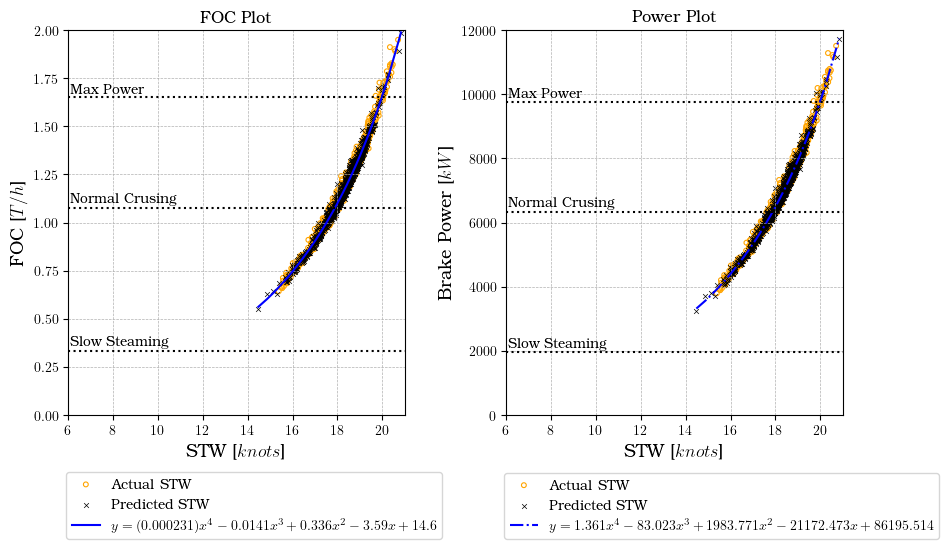

In [435]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
coefs_act_yr,coefs_pred_et_yr = FOC_coeff_plot(stw_pred_et_yr,stw_act_yr,FOC_pred_yr,FOC_act_yr)
plt.sca(axes[1])
Pb_plot(stw_pred_et_yr,stw_act_yr,P_b_pred_yr,P_b_act_yr)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)

plt.show()

Compare FOC plot

Coefficients for FOC curve
[ 9.35598168e-05 -4.72543688e-03  9.87397618e-02 -9.23425858e-01
  3.46686454e+00]
[-8.69601482e-04  6.59925043e-02 -1.84193310e+00  2.26682124e+01
 -1.03725679e+02]
Coefficients for FOC curve
[ 1.29108102e-03 -8.76741961e-02  2.24673920e+00 -2.55685319e+01
  1.09174502e+02]
[ 2.93553083e-04 -1.72358623e-02  3.84875719e-01 -3.73660114e+00
  1.33626879e+01]


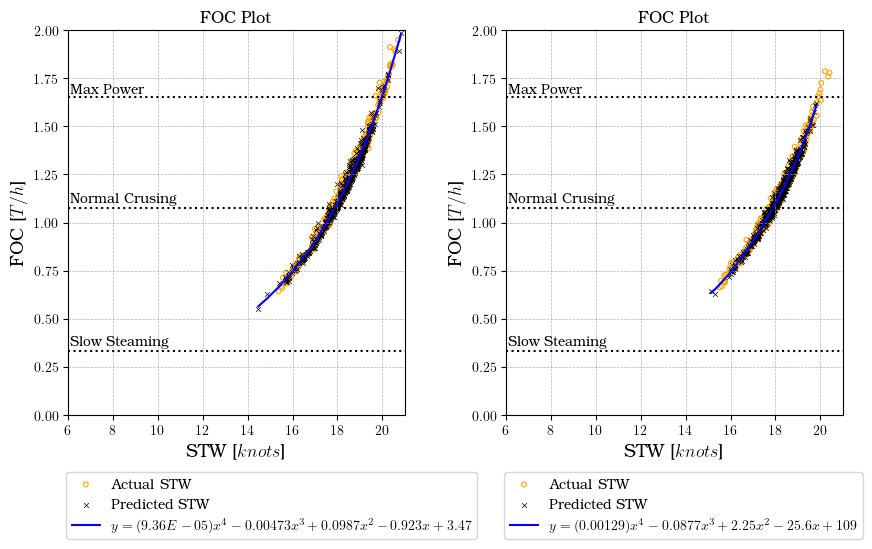

In [436]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
coefs_act_s,coefs_pred_et_s = FOC_coeff_plot(stw_pred_et_s,stw_act_s,FOC_pred_s,FOC_act_s)
plt.sca(axes[1])
coefs_act_w,coefs_pred_et_w = FOC_coeff_plot(stw_pred_et_w,stw_act_w,FOC_pred_w,FOC_act_w)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)

plt.show()

Compare Power Plot

Coefficients for power curve
[ 5.52301161e-01 -2.78951410e+01  5.82879349e+02 -5.45115618e+03
  2.04655522e+04]
[-5.13342079e+00  3.89566141e+02 -1.08732768e+04  1.33814713e+05
 -6.12312154e+05]
Coefficients for power curve
[ 7.62149364e+00 -5.17557238e+02  1.32629233e+04 -1.50935844e+05
  6.44477578e+05]
[ 1.73289896e+00 -1.01746531e+02  2.27199362e+03 -2.20578580e+04
  7.88824550e+04]


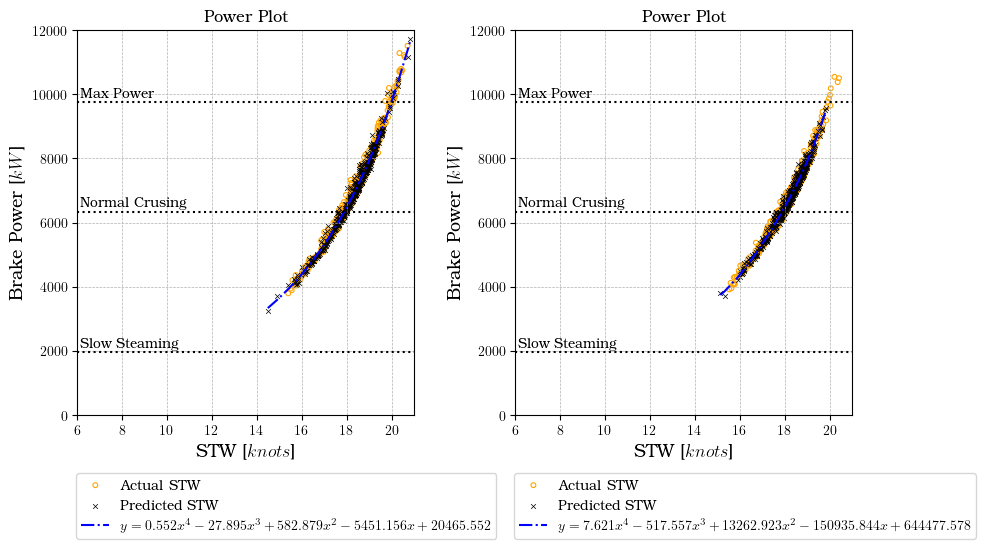

In [437]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
Pb_plot(stw_pred_et_s,stw_act_s,P_b_pred_s,P_b_act_s)
plt.sca(axes[1])
Pb_plot(stw_pred_et_w,stw_act_w,P_b_pred_w,P_b_act_w)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)
plt.show()

RFR

Compare FOC plot

Coefficients for FOC curve
[ 1.21119325e-04 -6.30875308e-03  1.30468656e-01 -1.17074855e+00
  3.97972994e+00]
[-8.69601482e-04  6.59925043e-02 -1.84193310e+00  2.26682124e+01
 -1.03725679e+02]
Coefficients for FOC curve
[ 8.36723665e-04 -5.52546131e-02  1.38069179e+00 -1.53036568e+01
  6.36313678e+01]
[ 2.93553083e-04 -1.72358623e-02  3.84875719e-01 -3.73660114e+00
  1.33626879e+01]


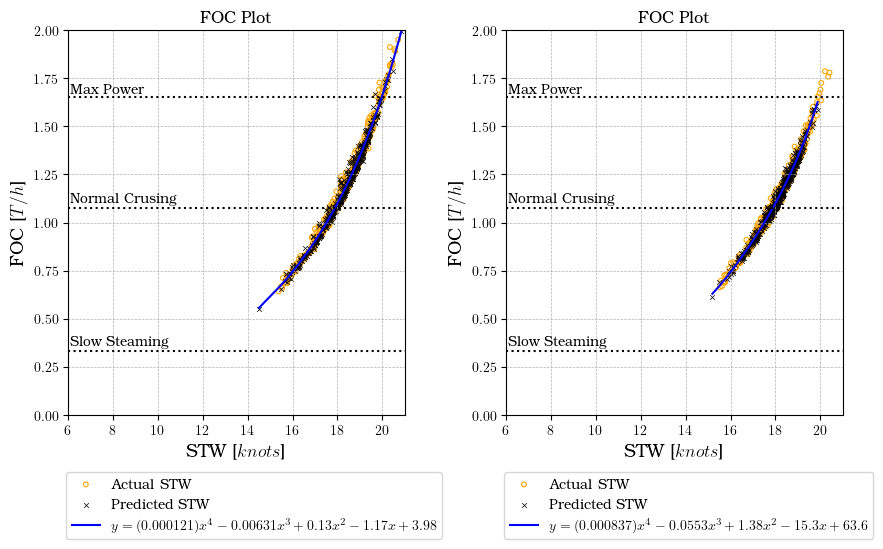

In [438]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
coefs_act_s,coefs_pred_rf_s = FOC_coeff_plot(stw_pred_rf_s,stw_act_s,FOC_pred_rf_s,FOC_act_s)
plt.sca(axes[1])
coefs_act_w,coefs_pred_rf_w = FOC_coeff_plot(stw_pred_rf_w,stw_act_w,FOC_pred_rf_w,FOC_act_w)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)

plt.show()

Compare Power plot

Coefficients for power curve
[ 7.14990110e-01 -3.72417537e+01  7.70180969e+02 -6.91114845e+03
  2.34930929e+04]
[-5.13342079e+00  3.89566141e+02 -1.08732768e+04  1.33814713e+05
 -6.12312154e+05]
Coefficients for power curve
[ 4.93933686e+00 -3.26178354e+02  8.15048281e+03 -9.03403587e+04
  3.75627909e+05]
[ 1.73289896e+00 -1.01746531e+02  2.27199362e+03 -2.20578580e+04
  7.88824550e+04]


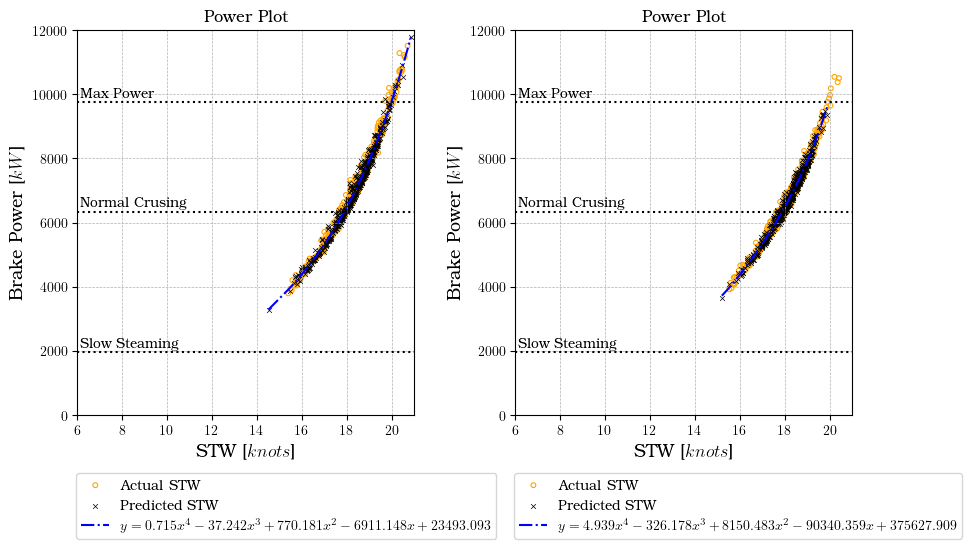

In [439]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
Pb_plot(stw_pred_rf_s,stw_act_s,P_b_pred_rf_s,P_b_act_s)
plt.sca(axes[1])
Pb_plot(stw_pred_rf_w,stw_act_w,P_b_pred_rf_w,P_b_act_w)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)
plt.show()

DTR

compare FOC plot

Coefficients for FOC curve
[ 3.46694094e-04 -2.20659945e-02  5.40792683e-01 -5.89226499e+00
  2.42402505e+01]
[-8.69601482e-04  6.59925043e-02 -1.84193310e+00  2.26682124e+01
 -1.03725679e+02]
Coefficients for FOC curve
[ 1.21280752e-03 -8.14183085e-02  2.06107493e+00 -2.31423922e+01
  9.73923311e+01]
[ 2.93553083e-04 -1.72358623e-02  3.84875719e-01 -3.73660114e+00
  1.33626879e+01]


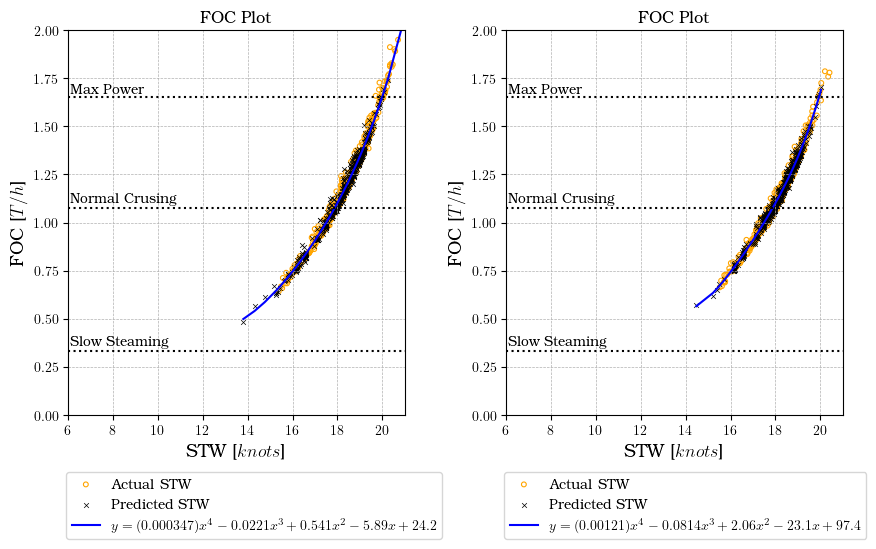

In [440]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
coefs_act_s,coefs_pred_dt_s = FOC_coeff_plot(stw_pred_dt_s,stw_act_s,FOC_pred_dt_s,FOC_act_s)
plt.sca(axes[1])
coefs_act_w,coefs_pred_dt_w = FOC_coeff_plot(stw_pred_dt_w,stw_act_w,FOC_pred_dt_w,FOC_act_w)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)
plt.show()

Compare power plot

Coefficients for power curve
[ 2.04660032e+00 -1.30259708e+02  3.19240073e+03 -3.47831463e+04
  1.43094749e+05]
[-5.13342079e+00  3.89566141e+02 -1.08732768e+04  1.33814713e+05
 -6.12312154e+05]
Coefficients for power curve
[ 7.15943044e+00 -4.80627559e+02  1.21669122e+04 -1.36613886e+05
  5.74925213e+05]
[ 1.73289896e+00 -1.01746531e+02  2.27199362e+03 -2.20578580e+04
  7.88824550e+04]


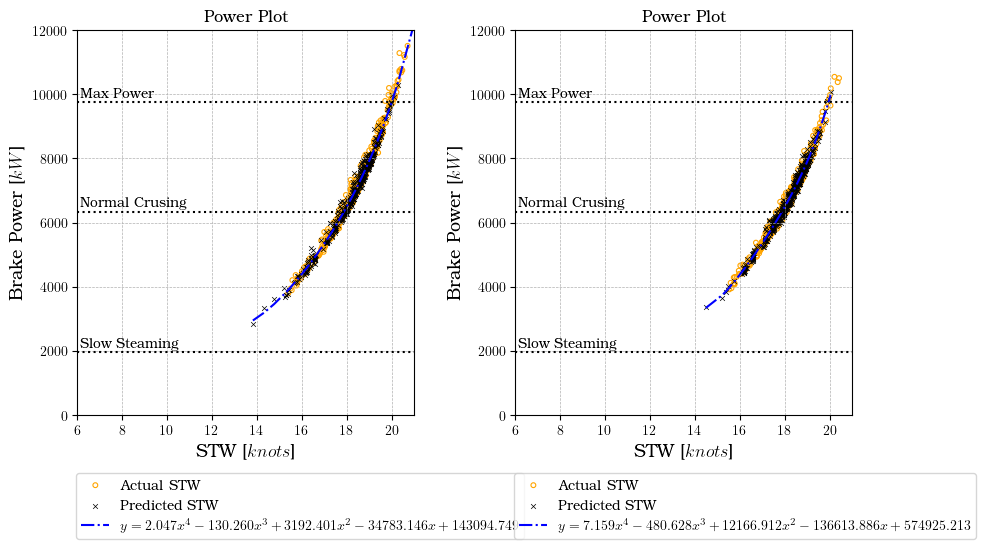

In [441]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
Pb_plot(stw_pred_dt_s,stw_act_s,P_b_pred_dt_s,P_b_act_s)
plt.sca(axes[1])
Pb_plot(stw_pred_dt_w,stw_act_w,P_b_pred_dt_w,P_b_act_w)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)
plt.show()

MLR

compare FOC Plot

Coefficients for FOC curve
[ 2.44595128e-04 -1.43163112e-02  3.20262888e-01 -3.11187049e+00
  1.11647219e+01]
[-8.69601482e-04  6.59925043e-02 -1.84193310e+00  2.26682124e+01
 -1.03725679e+02]
Coefficients for FOC curve
[ 1.53930670e-03 -1.08602314e-01  2.88523823e+00 -3.40078726e+01
  1.50206099e+02]
[ 2.93553083e-04 -1.72358623e-02  3.84875719e-01 -3.73660114e+00
  1.33626879e+01]


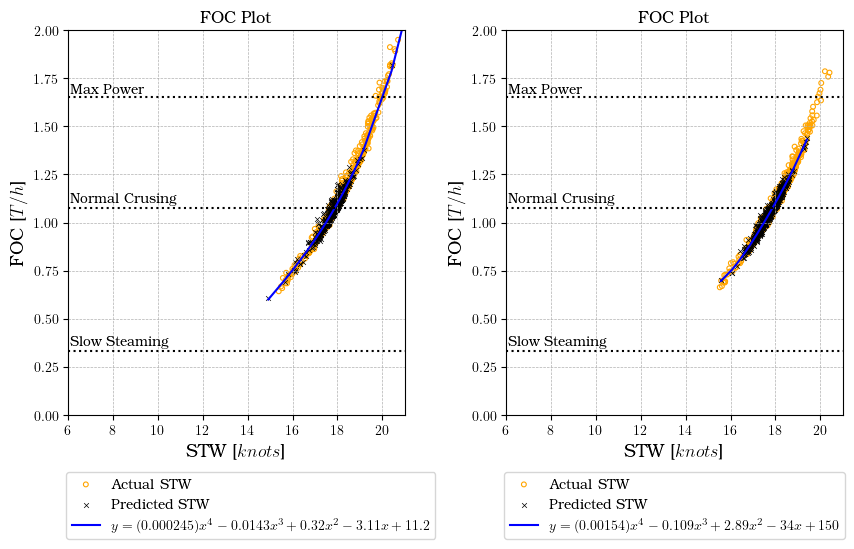

In [442]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
coefs_act_s,coefs_pred_mlr_s = FOC_coeff_plot(stw_pred_mlr_s,stw_act_s,FOC_pred_mlr_s,FOC_act_s)
plt.sca(axes[1])
coefs_act_w,coefs_pred_mlr_w = FOC_coeff_plot(stw_pred_mlr_w,stw_act_w,FOC_pred_mlr_w,FOC_act_w)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)
plt.show()

compare power plot

Coefficients for power curve
[ 1.44389096e+00 -8.45118725e+01  1.89057195e+03 -1.83699557e+04
  6.59074495e+04]
[-5.13342079e+00  3.89566141e+02 -1.08732768e+04  1.33814713e+05
 -6.12312154e+05]
Coefficients for power curve
[ 9.08681639e+00 -6.41099846e+02  1.70321029e+04 -2.00754856e+05
  8.86694799e+05]
[ 1.73289896e+00 -1.01746531e+02  2.27199362e+03 -2.20578580e+04
  7.88824550e+04]


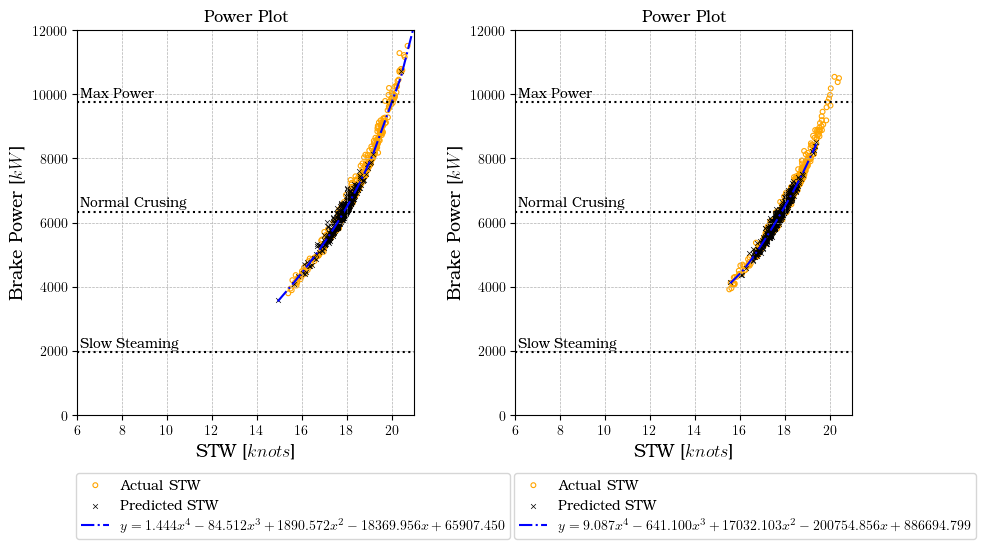

In [443]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
Pb_plot(stw_pred_mlr_s,stw_act_s,P_b_pred_mlr_s,P_b_act_s)
plt.sca(axes[1])
Pb_plot(stw_pred_mlr_w,stw_act_w,P_b_pred_mlr_w,P_b_act_w)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)
plt.show()

In [444]:
import random

# # Simulate model performance by inserting arbitrary STW in knots

# # Complete Random number with no distribution

# def generate_random_integers(min_value, max_value, n):
#     random_numbers = [random.uniform(min_value, max_value) for _ in range(n)]
#     return random_numbers
# # speed range, 5-21 kts, simulate 18h journey time in a day over a month so (18*31)
# v_stw_lst = generate_random_integers(19.5,21,558) 
# v_stw = np.array(v_stw_lst)
# print(v_stw)

# # Simulate one way trip

# v_stw_lst_day = [17.27621092,18.9989056,19.33427835,18.91104651,13.85493274]
# v_stw = np.array(v_stw_lst_day)

# Skewed distribution of random numbers

# Parameters for the right-skewed normal distribution
mean = 17  # Mean of the distribution
std_dev = -3.176740  # Standard deviation of the distribution
skewness_factor = .3  # Skewness factor to control the skewness

# Range of the random numbers you want to generate
minimum = 5
maximum = 21

# Generate random numbers with a standard normal distribution
n = 558  # Number of random numbers to generate
standard_normal_values = np.random.randn(n)

# Transform the standard normal distribution into a right-skewed distribution
right_skewed_values = mean + std_dev * np.exp(skewness_factor * standard_normal_values)

# Scale and shift the values to the desired range
scaled_values = (right_skewed_values - np.min(right_skewed_values)) / (np.max(right_skewed_values) - np.min(right_skewed_values))
v_stw = minimum + scaled_values * (maximum - minimum)

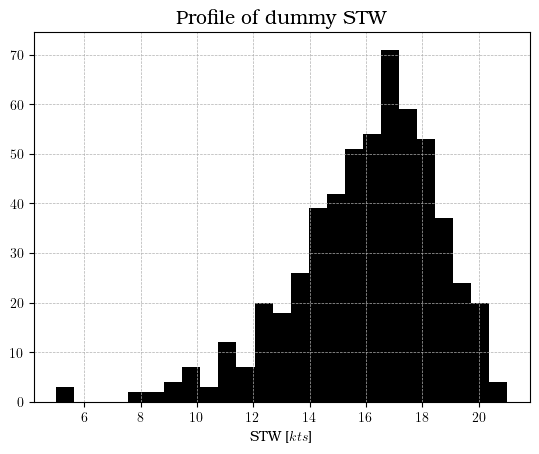

In [445]:
plt.hist(v_stw,bins=25,color='black')
plt.grid(True,linestyle = '--', linewidth = 0.5)
plt.xlabel(r"STW [$kts$]",fontsize=10)
plt.title(r"Profile of dummy STW", fontsize=14)
plt.show()

Actual

In [446]:
#Summer
FOC_poly_act_s = coefs_act_s[0]*v_stw**4 + coefs_act_s[1] * v_stw**3 + coefs_act_s[2] * v_stw**2 + coefs_act_s[3]*v_stw + coefs_act_s[4]
#Winter
FOC_poly_act_w = coefs_act_w[0]*v_stw**4 + coefs_act_w[1] * v_stw**3 + coefs_act_w[2] * v_stw**2 + coefs_act_w[3]*v_stw + coefs_act_s[4]
#Year
FOC_poly_act_yr = coefs_act_yr[0]*v_stw**4 + coefs_act_yr[1] * v_stw**3 + coefs_act_yr[2] * v_stw**2 + coefs_act_yr[3]*v_stw + coefs_act_yr[4]

ETR

In [447]:
#Summer
FOC_poly_pred_s = coefs_pred_et_s[0]*v_stw**4 + coefs_pred_et_s[1] * v_stw**3 + coefs_pred_et_s[2] * v_stw**2 + coefs_pred_et_s[3]*v_stw + coefs_pred_et_s[4]
#Winter
FOC_poly_pred_w = coefs_pred_et_w[0]*v_stw**4 + coefs_pred_et_w[1] * v_stw**3 + coefs_pred_et_w[2] * v_stw**2 + coefs_pred_et_w[3]*v_stw + coefs_pred_et_w[4]
#Yearly
FOC_poly_pred_yr = coefs_pred_et_yr[0]*v_stw**4 + coefs_pred_et_yr[1] * v_stw**3 + coefs_pred_et_yr[2] * v_stw**2 + coefs_pred_et_yr[3]*v_stw + coefs_pred_et_yr[4]


RFR

In [448]:
#Summer
FOC_poly_rf_s = coefs_pred_rf_s[0]*v_stw**4 + coefs_pred_rf_s[1] * v_stw**3 + coefs_pred_rf_s[2] * v_stw**2 + coefs_pred_rf_s[3]*v_stw + coefs_pred_rf_s[4]
#Winter
FOC_poly_rf_w = coefs_pred_rf_w[0]*v_stw**4 + coefs_pred_rf_w[1] * v_stw**3 + coefs_pred_rf_w[2] * v_stw**2 + coefs_pred_rf_w[3]*v_stw + coefs_pred_rf_w[4]


DTR

In [449]:
#Summer
FOC_poly_dt_s = coefs_pred_dt_s[0]*v_stw**4 + coefs_pred_dt_s[1] * v_stw**3 + coefs_pred_dt_s[2] * v_stw**2 + coefs_pred_dt_s[3]*v_stw + coefs_pred_dt_s[4]
#Winter
FOC_poly_dt_w = coefs_pred_dt_w[0]*v_stw**4 + coefs_pred_dt_w[1] * v_stw**3 + coefs_pred_dt_w[2] * v_stw**2 + coefs_pred_dt_w[3]*v_stw + coefs_pred_dt_w[4]


MLR

In [450]:
#Summer
FOC_poly_mlr_s = coefs_pred_mlr_s[0]*v_stw**4 + coefs_pred_mlr_s[1] * v_stw**3 + coefs_pred_mlr_s[2] * v_stw**2 + coefs_pred_mlr_s[3]*v_stw + coefs_pred_mlr_s[4]
#Winter
FOC_poly_mlr_w = coefs_pred_mlr_w[0]*v_stw**4 + coefs_pred_mlr_w[1] * v_stw**3 + coefs_pred_mlr_w[2] * v_stw**2 + coefs_pred_mlr_w[3]*v_stw + coefs_pred_mlr_w[4]


Polyfit model performance 

In [451]:
# This model defines the performance of the generated polyfit line from the model

def evaluate_FOC_poly(model,FOC_poly_act,FOC_poly_pred):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    Rsquared_ply = r2_score(FOC_poly_act,FOC_poly_pred)
    expVar_ply = explained_variance_score(FOC_poly_act,FOC_poly_pred)
    MAE_ply = mean_absolute_error(FOC_poly_act,FOC_poly_pred)
    RMSE_ply = np.sqrt(mean_squared_error(FOC_poly_act,FOC_poly_pred))
    MAD_ply = median_absolute_error(FOC_poly_act,FOC_poly_pred)
    MAPE_ply = mean_absolute_percentage_error(FOC_poly_act,FOC_poly_pred)
    
    n = len(FOC_poly_act)
    num_params = 4 + 1 # 4th order model is best fit
    aic_ply = n * np.log(mean_squared_error(FOC_poly_act,FOC_poly_pred)) + 2 * num_params

    print(f"Model Performance of {model}")
    print(f"AIC {aic_ply:0.4f}")
    print(f"R^2 {Rsquared_ply:0.4f}")
    print(f"Explained Variance {expVar_ply:0.4f}")
    print(f"MAE {MAE_ply:0.4f} T/h")    
    print(f"RMSE FOC {RMSE_ply:0.4f} T/h")
    print(f"MAD {MAD_ply:0.4f} T/h")    
    print(f"MAPE FOC {MAPE_ply*100:0.4f} %")

ETR

In [452]:
# Yearly
evaluate_FOC_poly(model_etr_hpov,FOC_poly_act_yr,FOC_poly_pred_yr)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
AIC 954.6265
R^2 -0.1273
Explained Variance -0.0774
MAE 0.4932 T/h
RMSE FOC 2.3313 T/h
MAD 0.0053 T/h
MAPE FOC 146.0216 %


In [453]:
# Summer
evaluate_FOC_poly(model_etr_hpov,FOC_poly_act_s,FOC_poly_pred_s)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
AIC 958.7446
R^2 0.0433
Explained Variance 0.0865
MAE 0.5006 T/h
RMSE FOC 2.3400 T/h
MAD 0.0055 T/h
MAPE FOC 148.5328 %


In [454]:
# Winter
evaluate_FOC_poly(model_etr_hpov,FOC_poly_act_w,FOC_poly_pred_w)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
AIC 5329.1721
R^2 -92241.1200
Explained Variance -22.9444
MAE 117.4665 T/h
RMSE FOC 117.4818 T/h
MAD 117.0893 T/h
MAPE FOC 101.0410 %


RFR

In [455]:
# Summer
evaluate_FOC_poly(model_rfr_hpov,FOC_poly_act_s,FOC_poly_rf_s)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
AIC 949.2328
R^2 0.0594
Explained Variance 0.1008
MAE 0.4889 T/h
RMSE FOC 2.3201 T/h
MAD 0.0049 T/h
MAPE FOC 140.2992 %


In [456]:
# Winter
evaluate_FOC_poly(model_rfr_hpov,FOC_poly_act_w,FOC_poly_rf_w)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
AIC 5327.2496
R^2 -91923.8580
Explained Variance -5.2883
MAE 117.2756 T/h
RMSE FOC 117.2796 T/h
MAD 117.0889 T/h
MAPE FOC 100.8768 %


DTR

In [457]:
# Summer
evaluate_FOC_poly(model_dtr_hpov,FOC_poly_act_s,FOC_poly_dt_s)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
AIC 1119.1180
R^2 -0.2753
Explained Variance -0.2216
MAE 0.5569 T/h
RMSE FOC 2.7016 T/h
MAD 0.0052 T/h
MAPE FOC 151.2312 %


In [458]:
# Winter
evaluate_FOC_poly(model_dtr_hpov,FOC_poly_act_w,FOC_poly_dt_w)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
AIC 5328.4516
R^2 -92122.0926
Explained Variance -16.2531
MAE 117.3950 T/h
RMSE FOC 117.4060 T/h
MAD 117.0905 T/h
MAPE FOC 100.9795 %


MLR

In [459]:
# Summer
evaluate_FOC_poly(model_mlr_ftr,FOC_poly_act_s,FOC_poly_mlr_s)

Model Performance of LinearRegression()
AIC 984.7572
R^2 -0.0024
Explained Variance 0.0390
MAE 0.4923 T/h
RMSE FOC 2.3951 T/h
MAD 0.0116 T/h
MAPE FOC 130.3137 %


In [460]:
# Winter
evaluate_FOC_poly(model_mlr_ftr,FOC_poly_act_w,FOC_poly_mlr_w)

Model Performance of LinearRegression()
AIC 5331.5677
R^2 -92637.9857
Explained Variance -54.4239
MAE 117.6990 T/h
RMSE FOC 117.7342 T/h
MAD 117.0915 T/h
MAPE FOC 101.2409 %


Absolute model performance

In [461]:
# This function defines the model performance for the given stw range

def evaluate_FOC(model,FOC_act,FOC_pred):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    Rsquared_FOC = r2_score(FOC_act,FOC_pred)
    expVar_FOC = explained_variance_score(FOC_act,FOC_pred)
    MAE_FOC = mean_absolute_error(FOC_act,FOC_pred)
    RMSE_FOC = np.sqrt(mean_squared_error(FOC_act, FOC_pred))
    MAD_FOC = median_absolute_error(FOC_act,FOC_pred)
    MAPE_FOC = mean_absolute_percentage_error(FOC_act, FOC_pred)
    
    n = len(FOC_act)
    num_params = model.n_features_in_
    aic = n * math.log(mean_squared_error(FOC_act, FOC_pred)) + 2 * num_params

    print(f"Model Performance of {model}")
    print(f"AIC {aic:0.4f}")
    print(f"R^2 {Rsquared_FOC:0.4f}")
    print(f"Explained Variance {expVar_FOC:0.4f}")
    print(f"MAE {MAE_FOC:0.4f} T/h")    
    print(f"RMSE FOC {RMSE_FOC:0.4f} T/h")
    print(f"MAD {MAD_FOC:0.4f} T/h")    
    print(f"MAPE FOC {MAPE_FOC*100:0.4f} %")


ETR

In [462]:
# Yearly performance 

evaluate_FOC(model_etr_hpov,FOC_act_yr,FOC_pred_yr)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
AIC -3459.5249
R^2 0.8139
Explained Variance 0.8218
MAE 0.0712 T/h
RMSE FOC 0.1097 T/h
MAD 0.0454 T/h
MAPE FOC 5.9038 %


In [463]:
evaluate_FOC(model_etr_hpov,FOC_act_s,FOC_pred_s)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
AIC -1535.3096
R^2 0.7991
Explained Variance 0.8178
MAE 0.0836 T/h
RMSE FOC 0.1299 T/h
MAD 0.0499 T/h
MAPE FOC 6.5594 %


In [464]:
evaluate_FOC(model_etr_hpov,FOC_act_w,FOC_pred_w)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
AIC -1964.4776
R^2 0.8288
Explained Variance 0.8297
MAE 0.0595 T/h
RMSE FOC 0.0864 T/h
MAD 0.0410 T/h
MAPE FOC 5.2869 %


RFR

In [465]:
# On yearly data

evaluate_FOC(model_rfr_hpov,FOC_act_yr,FOC_pred_rf_yr)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
AIC -3503.8177
R^2 0.8241
Explained Variance 0.8290
MAE 0.0672 T/h
RMSE FOC 0.1066 T/h
MAD 0.0413 T/h
MAPE FOC 5.5848 %


In [466]:
evaluate_FOC(model_rfr_hpov,FOC_act_s,FOC_pred_rf_s)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
AIC -1557.2323
R^2 0.8103
Explained Variance 0.8227
MAE 0.0793 T/h
RMSE FOC 0.1262 T/h
MAD 0.0464 T/h
MAPE FOC 6.2775 %


In [467]:
evaluate_FOC(model_rfr_hpov,FOC_act_w,FOC_pred_rf_w)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
AIC -1986.2811
R^2 0.8377
Explained Variance 0.8381
MAE 0.0558 T/h
RMSE FOC 0.0841 T/h
MAD 0.0370 T/h
MAPE FOC 4.9331 %


DTR

In [468]:
evaluate_FOC(model_dtr_hpov,FOC_act_yr,FOC_pred_dt_yr)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
AIC -2673.9775
R^2 0.4958
Explained Variance 0.5065
MAE 0.1293 T/h
RMSE FOC 0.1805 T/h
MAD 0.0914 T/h
MAPE FOC 10.9142 %


In [469]:
evaluate_FOC(model_dtr_hpov,FOC_act_s,FOC_pred_dt_s)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
AIC -1199.9550
R^2 0.5166
Explained Variance 0.5525
MAE 0.1413 T/h
RMSE FOC 0.2015 T/h
MAD 0.0968 T/h
MAPE FOC 11.3816 %


In [470]:
evaluate_FOC(model_dtr_hpov,FOC_act_w,FOC_pred_dt_w)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
AIC -1472.8470
R^2 0.4253
Explained Variance 0.4253
MAE 0.1180 T/h
RMSE FOC 0.1583 T/h
MAD 0.0865 T/h
MAPE FOC 10.4743 %


MLR

In [471]:
#yearly data

evaluate_FOC(model_mlr_ftr,FOC_act_yr,FOC_pred_mlr_yr)

Model Performance of LinearRegression()
AIC -2051.6576
R^2 -0.1106
Explained Variance 0.1332
MAE 0.2117 T/h
RMSE FOC 0.2679 T/h
MAD 0.1768 T/h
MAPE FOC 17.3557 %


In [472]:
evaluate_FOC(model_mlr_ftr,FOC_act_s,FOC_pred_mlr_s)

Model Performance of LinearRegression()
AIC -879.1934
R^2 -0.1194
Explained Variance 0.1633
MAE 0.2420 T/h
RMSE FOC 0.3066 T/h
MAD 0.2056 T/h
MAPE FOC 18.9711 %


In [473]:
evaluate_FOC(model_mlr_ftr,FOC_act_w,FOC_pred_mlr_w)

Model Performance of LinearRegression()
AIC -1185.2185
R^2 -0.1671
Explained Variance 0.0564
MAE 0.1832 T/h
RMSE FOC 0.2256 T/h
MAD 0.1603 T/h
MAPE FOC 15.8358 %


In [474]:
# fs = 10

# plt.rcParams.update(plt.rcParamsDefault)
# # Parameter to plot in nice latex fonts
# plt.rcParams.update({
# 	"text.usetex": True,
# 	"font.family": "serif",
# 	"font.serif": "bookman",
# 	})


# stw = stw_pred
# R_f = Rf_pred/1e3
# R_app = R_app_pred/1e3
# R_w = R_w_pred/1e3
# R_b = R_b_pred/1e3
# R_tr = R_tr_pred/1e3
# R_a = R_a_pred/1e3
# R_aa = R_aa_pred/1e3
# # R_aa_hm = dfprog_f['R_aa_hm']/1e3
# R_awl = R_awl_pred/1e3
# R_tot = R_tot_pred
# # eff_h = dfprog_f['eff_h']
# eff_tot = eff_tot_pred
# P_b = P_b_pred
# FOC = FOC_pred



# fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 15))

# axes[0, 0].hist(stw,bins=25,color='black')
# axes[0, 0].set_title(r'Speed Thorugh Water $[STW]$', fontsize=fs)
# axes[0, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[0, 1].hist(R_f,bins=25,color='black')
# axes[0, 1].set_title(r'Frictional Resistance $[kN]$', fontsize=fs)
# axes[0, 1].grid(True,linestyle = '--', linewidth = 0.5)

# axes[0, 2].hist(R_app,bins=25,color='black')
# axes[0, 2].set_title(r'Appendage Resistance $[kN]$', fontsize=fs)
# axes[0, 2].grid(True,linestyle = '--', linewidth = 0.5)

# axes[1, 0].hist(R_w,bins=25,color='black')
# axes[1, 0].set_title(r'Wave Making-Breaking Resistance $[kN]$', fontsize=fs)
# axes[1, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[1, 1].hist(R_b  ,bins=25,color='black')
# axes[1, 1].set_title(r'Bulbous Bow Resistance $[kN]$', fontsize=fs)
# axes[1, 1].grid(True,linestyle = '--', linewidth = 0.5)

# axes[1, 2].hist(R_a,bins=25,color='black')
# axes[1, 2].set_title(r'Correlation Resistance $[kN]$', fontsize=fs)
# axes[1, 2].grid(True,linestyle = '--', linewidth = 0.5)

# axes[2, 0].hist(R_aa,bins=25,color='black')
# axes[2, 0].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
# axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

# # axes[2, 0].hist(R_aa_hm,bins=25,color='black')
# # axes[2, 0].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
# # axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[2, 1].hist(R_awl,bins=25,color='black')
# axes[2, 1].set_title(r'Wave Resistance STAWAVE-1 $[kN]$', fontsize=fs)
# axes[2, 1].grid(True,linestyle = '--', linewidth = 0.5)

# axes[2, 2].hist(R_tr,bins=25,color='black')
# axes[2, 2].set_title(r'Transom Resistance $[kN]$', fontsize=fs)
# axes[2, 2].grid(True,linestyle = '--', linewidth = 0.5)

# axes[3, 0].hist(R_tot,bins=25,color='black')
# axes[3, 0].set_title(r'Total Resistance $[kN]$', fontsize=fs)
# axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

# # axes[3, 0].hist(eff_h,bins=25,color='black')
# # axes[3, 0].set_title(r'Hull Efficiency $[-]$', fontsize=fs)
# # axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[3, 1].hist(eff_tot,bins=25,color='black')
# axes[3, 1].set_title(r'Total Efficiency $[-]$', fontsize=fs)
# axes[3, 1].grid(True,linestyle = '--', linewidth = 0.5)

# axes[3, 2].hist(P_b,bins=25,color='black')
# axes[3, 2].set_title(r'Power $[kW]$', fontsize=fs)
# axes[3, 2].grid(True,linestyle = '--', linewidth = 0.5)

# # axes[4, 1].hist(FOC,bins=25,color='black')
# # axes[4, 1].set_title(r'Fuel Consumption $[t/h]$', fontsize=fs)
# # axes[4, 1].grid(True,linestyle = '--', linewidth = 0.5)

# fig.subplots_adjust(hspace=0.4)
# plt.show()